##Data Cleaning


In [ ]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
##STARTS HERE

##data Cleaning

#ALL of the imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PooledOLS, RandomEffects, PanelOLS
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.spatial import ConvexHull

# input Excel file
input_path = 'cleaner_NATO_Gender_Model_Populated_NCGP_Data.xlsx'

# where Excel will be saved
output_path = 'merged_nato_gender_data2.xlsx'

column_mapping = {
    'Urbanization % (world Bank)': 'Urbanization % (World Bank)',
    'Tertiary education rate (women) (UNESCO)': 'Tertiary education rate (women)',
    'Tertiary education rate (women) (OECD)':  'Tertiary education rate (women)',
    'Part-time Employment Available (Yes/No)': 'Part-time Employment Available',
    'Part-time Employment Available (1/0)':    'Part-time Employment Available',
    'Flexible Hours Available (Yes/No)':       'Flexible Hours Available',
    'Flexible Hours Available (1/0)':          'Flexible Hours Available',
    'Has gender recruitment policy (binary)':  'Has gender recruitment policy',
    'Has general retention policies (binary)': 'Has general retention policies',
    'Has specific retention policies targeting women (binary)':
        'Has specific retention policies targeting women',
    'Has Gender Advisor (1/0)':                'Has Gender Advisor',
    'Uses NATO Gender Training Package (1/0)': 'Uses NATO Gender Training Package',
    'Sexual Harassment Prevention Policy (1/0)': 'Sexual Harassment Prevention Policy',
    'Sexual Abuse Prevention Policy (Yes/No)':  'Sexual Abuse Prevention Policy',
    'Conscription type (none / male / both)':  'Conscription type',

}

# read all sheets
sheets = pd.read_excel(input_path, sheet_name=None)

yearly_dfs = []
for sheet_name, df in sheets.items():
    if sheet_name.lower() == 'sources':
        continue

    # standardize column names
    df = df.rename(columns=column_mapping)

    try:
        df['Year'] = int(sheet_name)
    except ValueError:
        raise ValueError(f"Sheet name '{sheet_name}' is not a valid year")

    yearly_dfs.append(df)

# merge into one DataFrame
master_df = pd.concat(yearly_dfs, ignore_index=True)
import numpy as np
master_df.columns = master_df.columns.str.strip()

#identify every name that appears more than once
dup_names = master_df.columns[master_df.columns.duplicated(keep=False)].unique()
print("Will merge duplicates for:", dup_names)

for name in dup_names:
    idxs = np.where(master_df.columns == name)[0]
    merged = master_df.iloc[:, idxs].bfill(axis=1).iloc[:, 0]
    master_df = master_df.drop(master_df.columns[idxs], axis=1)

    master_df.insert(idxs[0], name, merged)
    print(f"  • Merged columns at positions {list(idxs)} into one “{name}”")

print("Remaining '% women who left':", [c for c in master_df.columns if c == '% women who left'])
print(master_df['% women who left'].head())

# save
master_df.to_excel(output_path, index=False)
print(f"Final cleaned dataset saved to {output_path}")

"""Converting Data types"""

print("Before conversion:")
print(master_df.info())

# change to numeric

skip_cols = ['Country', 'Year', 'Conscription type']# skip columns that should remain as strings or categorical
for col in master_df.columns:
    if col not in skip_cols and master_df[col].dtype == 'object':
        master_df[col] = pd.to_numeric(master_df[col], errors='coerce')

# binary cols to nullable Int64
binary_cols = [
    'Part-time Employment Available',
    'Flexible Hours Available',
    'Has gender recruitment policy',
    'Has general retention policies',
    'Has specific retention policies targeting women',
    'Has Gender Advisor',
    'Uses NATO Gender Training Package',
    'Sexual Harassment Prevention Policy',
    'Sexual Abuse Prevention Policy'
]
for col in binary_cols:
    if col in master_df.columns:
        master_df[col] = pd.to_numeric(master_df[col], errors='coerce').astype('Int64')

master_df['Year']    = master_df['Year'].astype(int)
master_df['Country'] = master_df['Country'].astype(str)

print("\nAfter conversion:")
print(master_df.info())

# percentage of missing values by column
missing_pct = master_df.isnull().mean() * 100
print(missing_pct.sort_values(ascending=False))

"""Handling missing values"""

# missingness per country
country_missing = (
    master_df
    .groupby('Country')
    .apply(lambda d: d.isnull().mean() * 100)
)
display(country_missing)

# drop low-coverage columns that are only available in the NCGP report of 2019
to_drop = [
    'Paternity Leave Weeks',
    'Mean Childbearing Age',
    'Currently married (20-24) %',
    'Has gender recruitment policy'
]
existing = [c for c in to_drop if c in master_df.columns]
missing = [c for c in to_drop if c not in master_df.columns]
print(f"Dropping columns: {existing}")
if missing:
    print(f"Skipped (not found): {missing}")
master_df = master_df.drop(columns=existing, errors='ignore')

# missingness by column
missing_pct = master_df.isnull().mean() * 100
print("\n=== Missingness by column (%) ===")
print(missing_pct.sort_values(ascending=False).round(1))

# define continuous columns for imputation and future standardization
all_continuous_cols = [
    'GDP per capita (World Bank)',
    'Female labor force participation (World Bank) %',
    'Tertiary education rate (women)',
    'Gender wage gap (World Bank)',
    'Urbanization % (World Bank)',
    'Parental Leave Weeks',
    'Maternity Leave Weeks',
    '% of women in the military', # Dependent variable for recruitment
    '% women who left',           # Dependent variable for retention
    '% women in OF-6+'
]
# filter to ensure only columns present in the DataFrame are selected for imputation
all_continuous_cols_present = [col for col in all_continuous_cols if col in master_df.columns]

# interpolate numeric covariates within each country
master_df[all_continuous_cols_present] = (
    master_df
    .groupby('Country')[all_continuous_cols_present]
    .transform(lambda g: g.interpolate(method='linear').ffill().bfill())
)

# global mean imputation for any remaining NaNs in continuous columns
print("\n--- Performing Global Mean Imputation for remaining continuous NaNs ---")
for col in all_continuous_cols_present:
    if master_df[col].isnull().any():
        master_df[col].fillna(master_df[col].mean(), inplace=True)
print("--- Global Mean Imputation Complete ---")


# fill binary policy flags
bin_cols = [
    'Part-time Employment Available',
    'Flexible Hours Available',
    'Has Gender Advisor',
    'Uses NATO Gender Training Package',
    'Has general retention policies',
    'Has specific retention policies targeting women',
    'Sexual Harassment Prevention Policy'
]

bin_cols_present = [col for col in bin_cols if col in master_df.columns]

master_df[bin_cols_present] = (
    master_df
    .groupby('Country')[bin_cols_present]
    .transform(lambda g: g.ffill().bfill())
    .fillna(0) # fill any remaining NaNs with 0 (like if a country had no data for a binary flag)
    .astype('Int64')
)

#one-hot encode Conscription type
if 'Conscription type' in master_df.columns:
    cons_dummies = pd.get_dummies(master_df['Conscription type'], prefix='Conscription')
    master_df = master_df.drop(columns=['Conscription type'])
    master_df = pd.concat([master_df, cons_dummies], axis=1)

    for col in cons_dummies.columns:
        master_df[col] = master_df[col].astype('Int64')

# Data Standardization
from sklearn.preprocessing import StandardScaler

# 1. Identify continuous independent variables that need standardization
continuous_independent_vars_for_regression = [
    'GDP per capita (World Bank)',
    'Female labor force participation (World Bank) %',
    'Tertiary education rate (women)',
    'Gender wage gap (World Bank)',
    'Urbanization % (World Bank)',
    'Parental Leave Weeks',
    'Maternity Leave Weeks',
    '% women in OF-6+'
]

continuous_independent_vars_for_regression = [
    col for col in continuous_independent_vars_for_regression if col in master_df.columns
]


# master_df will now contain scaled IVs, and unscaled DVs.
print("\n--- Standardizing Continuous Independent Variables for Regression ---")
scaler_ivs = StandardScaler()
master_df[continuous_independent_vars_for_regression] = scaler_ivs.fit_transform(
    master_df[continuous_independent_vars_for_regression]
)
print("--- Standardization of Continuous Independent Variables Complete ---")


# 2. For Clustering: Prepare a separate dataset where ALL continuous variables are standardized.
# not needed in the end because we are doing a two stage clustering (would have been needed for one Stage), so we will just use master_df there
clustering_df = master_df.copy()

dependent_vars_for_clustering_only = ['% of women in the military', '% women who left']
dependent_vars_for_clustering_only = [
    col for col in dependent_vars_for_clustering_only if col in clustering_df.columns
]

# combine all continuous columns for clustering (already scaled IVs + DVs to be scaled)
all_continuous_cols_for_clustering = list(
    set(continuous_independent_vars_for_regression + dependent_vars_for_clustering_only)
)

print("--- Preparing Separate Dataset for Clustering with ALL Continuous Variables Standardized ---")
scaler_clustering = StandardScaler()
clustering_df[all_continuous_cols_for_clustering] = scaler_clustering.fit_transform(
    clustering_df[all_continuous_cols_for_clustering]
)
print("--- Separate Dataset for Clustering created and scaled ---")


#3 Build recruitment regression dataset
rec_dv = '% of women in the military' # this DV will remain unstandardized
print(f"\n--- Preparing Recruitment Regression Dataset (DV: '{rec_dv}') ---")

# 3.1) count non-null DV observations per country
rec_counts_all_years = master_df.groupby('Country')[rec_dv].count()
print(f"Number of non-null '{rec_dv}' observations per country:\n{rec_counts_all_years.sort_values(ascending=False).head()}")


# 3.2) identify countries that have at least 5 years of observed DV data
keep_countries_rec = rec_counts_all_years[rec_counts_all_years >= 5].index.tolist()
drop_countries_rec = rec_counts_all_years[rec_counts_all_years < 5].index.tolist()
print(f"\nKeeping {len(keep_countries_rec)} countries with >=5 years of '{rec_dv}' data: {keep_countries_rec}")
print(f"Dropping {len(drop_countries_rec)} countries with <5 years of '{rec_dv}' data: {drop_countries_rec}")

# create recruitment_df from the master_df
recruitment_df = master_df[master_df['Country'].isin(keep_countries_rec)].copy()
print(f"Total rows in recruitment_df after country filtering: {len(recruitment_df)}")

# 3.3) Impute mediators within each country
#will not be used in the end
med_cols = ['% applicants', '% of recruited applicants']
med_cols_present = [col for col in med_cols if col in recruitment_df.columns]

if med_cols_present:
    recruitment_df[med_cols_present] = (
        recruitment_df
        .groupby('Country')[med_cols_present]
        .transform(lambda g: g.interpolate(method='linear').ffill().bfill())
    )
    for col in med_cols_present:
        if recruitment_df[col].isnull().any():
            recruitment_df[col].fillna(recruitment_df[col].mean(), inplace=True)
else:
    print("Mediator columns for recruitment model not found in DataFrame, skipping imputation.")


print("\nFinal missingness in recruitment_df (should primarily be DV NaNs for relevant rows):")
print(recruitment_df.isnull().sum().sort_values(ascending=False).head(10))


# 4) Build retention regression dataset
ret_dv = '% women who left' # This DV will remain unstandardized in retention_df
years_keep = [2015, 2016, 2017, 2018, 2019]

print(f"\n--- Preparing Retention Regression Dataset (DV: '{ret_dv}') ---")

# 4.1 filter master_df to only include the relevant years
master_df_ret_years = master_df[master_df['Year'].isin(years_keep)].copy()
print(f"Rows in master_df for retention years ({years_keep}): {len(master_df_ret_years)}")

# 4.2 count non-null DV observations per country
ret_counts_all_years = master_df_ret_years.groupby('Country')[ret_dv].count()
print(f"\nNumber of non-null '{ret_dv}' observations per country (within {years_keep}):\n{ret_counts_all_years.sort_values(ascending=False).head()}")


# 4.3 identify countries that have at least 3 years of observed DV data within the specified years
keep_countries_ret = ret_counts_all_years[ret_counts_all_years >= 3].index.tolist()
drop_countries_ret = ret_counts_all_years[ret_counts_all_years < 3].index.tolist()
print(f"\nKeeping {len(keep_countries_ret)} countries with >=3 years of '{ret_dv}' data (within {years_keep}): {keep_countries_ret}")
print(f"Dropping {len(drop_countries_ret)} countries with <3 years of '{ret_dv}' data (within {years_keep}): {drop_countries_ret}")

retention_df = master_df_ret_years[master_df_ret_years['Country'].isin(keep_countries_ret)].copy()
print(f"Total rows in retention_df after country filtering: {len(retention_df)}")


# NEW: creating Lagged Policy Variables for retention_df here
# not sure if it will be included in the report, but there is a section on this later in the code
print("\nCreating lagged policy variables (1-year lag) for retention_df...")
policies_to_lag = [
    'Flexible Hours Available',
    'Sexual Harassment Prevention Policy',
    'Has general retention policies',
    'Parental Leave Weeks',
    'Part-time Employment Available',
    'Has Gender Advisor',
    'Uses NATO Gender Training Package',
    'Has specific retention policies targeting women',
    'Maternity Leave Weeks',
]

policies_to_lag_present = [col for col in policies_to_lag if col in retention_df.columns]

for policy_col in policies_to_lag_present:
    lagged_col_name = f"{policy_col}_lag1"
    # group by 'Country' column and then shift
    # this ensures lagging occurs independently for each country
    retention_df[lagged_col_name] = retention_df.groupby('Country')[policy_col].shift(1)
    print(f"Created lagged variable: {lagged_col_name}")

if not policies_to_lag_present:
    print("Warning: No specified policies to lag were found in retention_df.")
print("Lagged policy variables creation complete for retention_df.")


# 4.4 Drop mediators from retention dataset
med_cols_to_drop_retention = ['% applicants', '% of recruited applicants']
retention_df = retention_df.drop(columns=[col for col in med_cols_to_drop_retention if col in retention_df.columns], errors='ignore')

print("\nFinal missingness in retention_df (should primarily be DV NaNs for relevant rows):")
print(retention_df.isnull().sum().sort_values(ascending=False).head(10))

# save
recruitment_df.to_excel('cleaned_recruitment_data.xlsx', index=False)
print("\nSaved recruitment data → cleaned_recruitment_data.xlsx")

retention_df.to_excel('cleaned_retention_data.xlsx', index=False)
print("Saved retention data → cleaned_retention_data.xlsx")

print(recruitment_df.isnull().sum().clip(lower=0).sort_values(ascending=False).head())
print(retention_df.isnull().sum().clip(lower=0).sort_values(ascending=False).head())


Will merge duplicates for: Index(['% women who left'], dtype='object')
  • Merged columns at positions [np.int64(17), np.int64(26)] into one “% women who left”
Remaining '% women who left': ['% women who left']
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: % women who left, dtype: float64
Final cleaned dataset saved to merged_nato_gender_data2.xlsx
Before conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 26 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Country                                          288 non-null    object 
 1   Year                                             288 non-null    int64  
 2   GDP per capita (World Bank)                      288 non-null    float64
 3   Female labor force participation (World Bank) %  288 non-null    float64
 4   Tertiary education rate (women)                  286

/tmp/ipython-input-3-1440985597.py:132: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.isnull().mean() * 100)


,Country,Year,GDP per capita (World Bank),Female labor force participation (World Bank) %,Tertiary education rate (women),Gender wage gap (World Bank),Urbanization % (World Bank),Part-time Employment Available,Flexible Hours Available,Conscription type,...,Has specific retention policies targeting women,% women who left,% women in OF-6+,Sexual Harassment Prevention Policy,Parental Leave Weeks,Maternity Leave Weeks,Paternity Leave Weeks,Mean Childbearing Age,Currently married (20-24) %,Has gender recruitment policy
Country,,,,,,,,,,,,,,,,,,,,,
Albania,0.0,0.0,0.0,0.0,0.000000,100.0,0.0,11.111111,11.111111,0.0,...,0.000000,44.444444,0.000000,0.000000,33.333333,22.222222,55.555556,88.888889,88.888889,88.888889
Belgium,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,11.111111,11.111111,0.0,...,0.000000,44.444444,0.000000,0.000000,33.333333,22.222222,55.555556,88.888889,88.888889,88.888889
Bulgaria,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,22.222222,22.222222,0.0,...,11.111111,100.000000,44.444444,11.111111,33.333333,22.222222,66.666667,88.888889,88.888889,88.888889
Canada,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,11.111111,11.111111,0.0,...,0.000000,44.444444,0.000000,0.000000,33.333333,22.222222,66.666667,88.888889,88.888889,88.888889
Croatia,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,11.111111,11.111111,0.0,...,0.000000,44.444444,11.111111,0.000000,33.333333,33.333333,77.777778,88.888889,88.888889,88.888889
Czech Republic,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,22.222222,22.222222,0.0,...,11.111111,66.666667,22.222222,11.111111,44.444444,66.666667,100.000000,88.888889,88.888889,88.888889
Denmark,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,33.333333,33.333333,0.0,...,22.222222,55.555556,22.222222,22.222222,44.444444,33.333333,66.666667,88.888889,88.888889,88.888889
Estonia,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,33.333333,33.333333,0.0,...,22.222222,55.555556,22.222222,22.222222,55.555556,55.555556,77.777778,88.888889,88.888889,88.888889
Finland,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,100.000000,100.000000,0.0,...,88.888889,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,88.888889,88.888889,88.888889


Dropping columns: ['Paternity Leave Weeks', 'Mean Childbearing Age', 'Currently married (20-24) %', 'Has gender recruitment policy']

=== Missingness by column (%) ===
% women who left                                   60.4
% of recruited applicants                          45.8
Parental Leave Weeks                               43.1
Maternity Leave Weeks                              41.7
% applicants                                       39.9
Part-time Employment Available                     25.0
Flexible Hours Available                           24.7
% women in OF-6+                                   20.8
% of women in the military                         18.1
Has general retention policies                     14.9
Has specific retention policies targeting women    14.6
Uses NATO Gender Training Package                  13.9
Sexual Harassment Prevention Policy                13.9
Has Gender Advisor                                 12.5
Gender wage gap (World Bank)                    

/tmp/ipython-input-3-1440985597.py:182: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master_df[col].fillna(master_df[col].mean(), inplace=True)


Total rows in recruitment_df after country filtering: 288

Final missingness in recruitment_df (should primarily be DV NaNs for relevant rows):
Country                                            0
Year                                               0
GDP per capita (World Bank)                        0
Female labor force participation (World Bank) %    0
Tertiary education rate (women)                    0
Gender wage gap (World Bank)                       0
Urbanization % (World Bank)                        0
Part-time Employment Available                     0
Flexible Hours Available                           0
Has Gender Advisor                                 0
dtype: int64

--- Preparing Retention Regression Dataset (DV: '% women who left') ---
Rows in master_df for retention years ([2015, 2016, 2017, 2018, 2019]): 160

Number of non-null '% women who left' observations per country (within [2015, 2016, 2017, 2018, 2019]):
Country
Albania     5
Belgium     5
Bulgaria    5
Canada   

/tmp/ipython-input-3-1440985597.py:299: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  recruitment_df[col].fillna(recruitment_df[col].mean(), inplace=True)



Saved recruitment data → cleaned_recruitment_data.xlsx
Saved retention data → cleaned_retention_data.xlsx
Country                                            0
Year                                               0
GDP per capita (World Bank)                        0
Female labor force participation (World Bank) %    0
Tertiary education rate (women)                    0
dtype: int64
Has general retention policies_lag1       32
Parental Leave Weeks_lag1                 32
Part-time Employment Available_lag1       32
Has Gender Advisor_lag1                   32
Uses NATO Gender Training Package_lag1    32
dtype: int64


In [ ]:
print(recruitment_df.isnull().sum().clip(lower=0).sort_values(ascending=False).head())
print(retention_df.isnull().sum().clip(lower=0).sort_values(ascending=False).head())


Country                                            0
Year                                               0
GDP per capita (World Bank)                        0
Female labor force participation (World Bank) %    0
Tertiary education rate (women)                    0
dtype: int64
Has general retention policies_lag1       32
Parental Leave Weeks_lag1                 32
Part-time Employment Available_lag1       32
Has Gender Advisor_lag1                   32
Uses NATO Gender Training Package_lag1    32
dtype: int64


##EDA

--- Starting Exploratory Data Analysis (EDA) ---

--- 1. Descriptive Statistics ---

Descriptive statistics for numeric variables:


,count,mean,std,min,25%,50%,75%,max
GDP per capita (World Bank),288.0,-0.0,1.001741,-1.201094,-0.748289,-0.358602,0.585789,3.933797
Female labor force participation (World Bank) %,288.0,-0.0,1.001741,-5.073836,-0.254896,0.157105,0.505606,1.525738
Tertiary education rate (women),288.0,0.0,1.001741,-3.105465,-0.647764,0.047046,0.575024,4.193912
Gender wage gap (World Bank),288.0,-0.0,1.001741,-2.306529,-0.804467,-0.0,0.847802,1.899245
Urbanization % (World Bank),288.0,-0.0,1.001741,-1.661308,-0.684534,0.048047,0.69923,1.920199
Part-time Employment Available,288.0,0.614583,0.487541,0.0,0.0,1.0,1.0,1.0
Flexible Hours Available,288.0,0.784722,0.41173,0.0,1.0,1.0,1.0,1.0
Has Gender Advisor,288.0,0.611111,0.488347,0.0,0.0,1.0,1.0,1.0
Uses NATO Gender Training Package,288.0,0.489583,0.500762,0.0,0.0,0.0,1.0,1.0
% of women in the military,288.0,11.359195,4.104834,0.3,8.9375,11.359195,14.6,20.7



Descriptive statistics for categorical/binary variables (value counts):

--- Part-time Employment Available ---


,count
Part-time Employment Available,
1,177
0,111



--- Flexible Hours Available ---


,count
Flexible Hours Available,
1,226
0,62



--- Has general retention policies ---


,count
Has general retention policies,
1,194
0,94



--- Has specific retention policies targeting women ---


,count
Has specific retention policies targeting women,
0,209
1,79



--- Has Gender Advisor ---


,count
Has Gender Advisor,
1,176
0,112



--- Uses NATO Gender Training Package ---


,count
Uses NATO Gender Training Package,
0,147
1,141



--- Sexual Harassment Prevention Policy ---


,count
Sexual Harassment Prevention Policy,
1,235
0,53



--- Conscription_both ---


,count
Conscription_both,
0,274
1,14



--- Conscription_male ---


,count
Conscription_male,
0,234
1,54



--- Conscription_none ---


,count
Conscription_none,
1,220
0,68



--- 2. Histograms for Numeric Variables ---


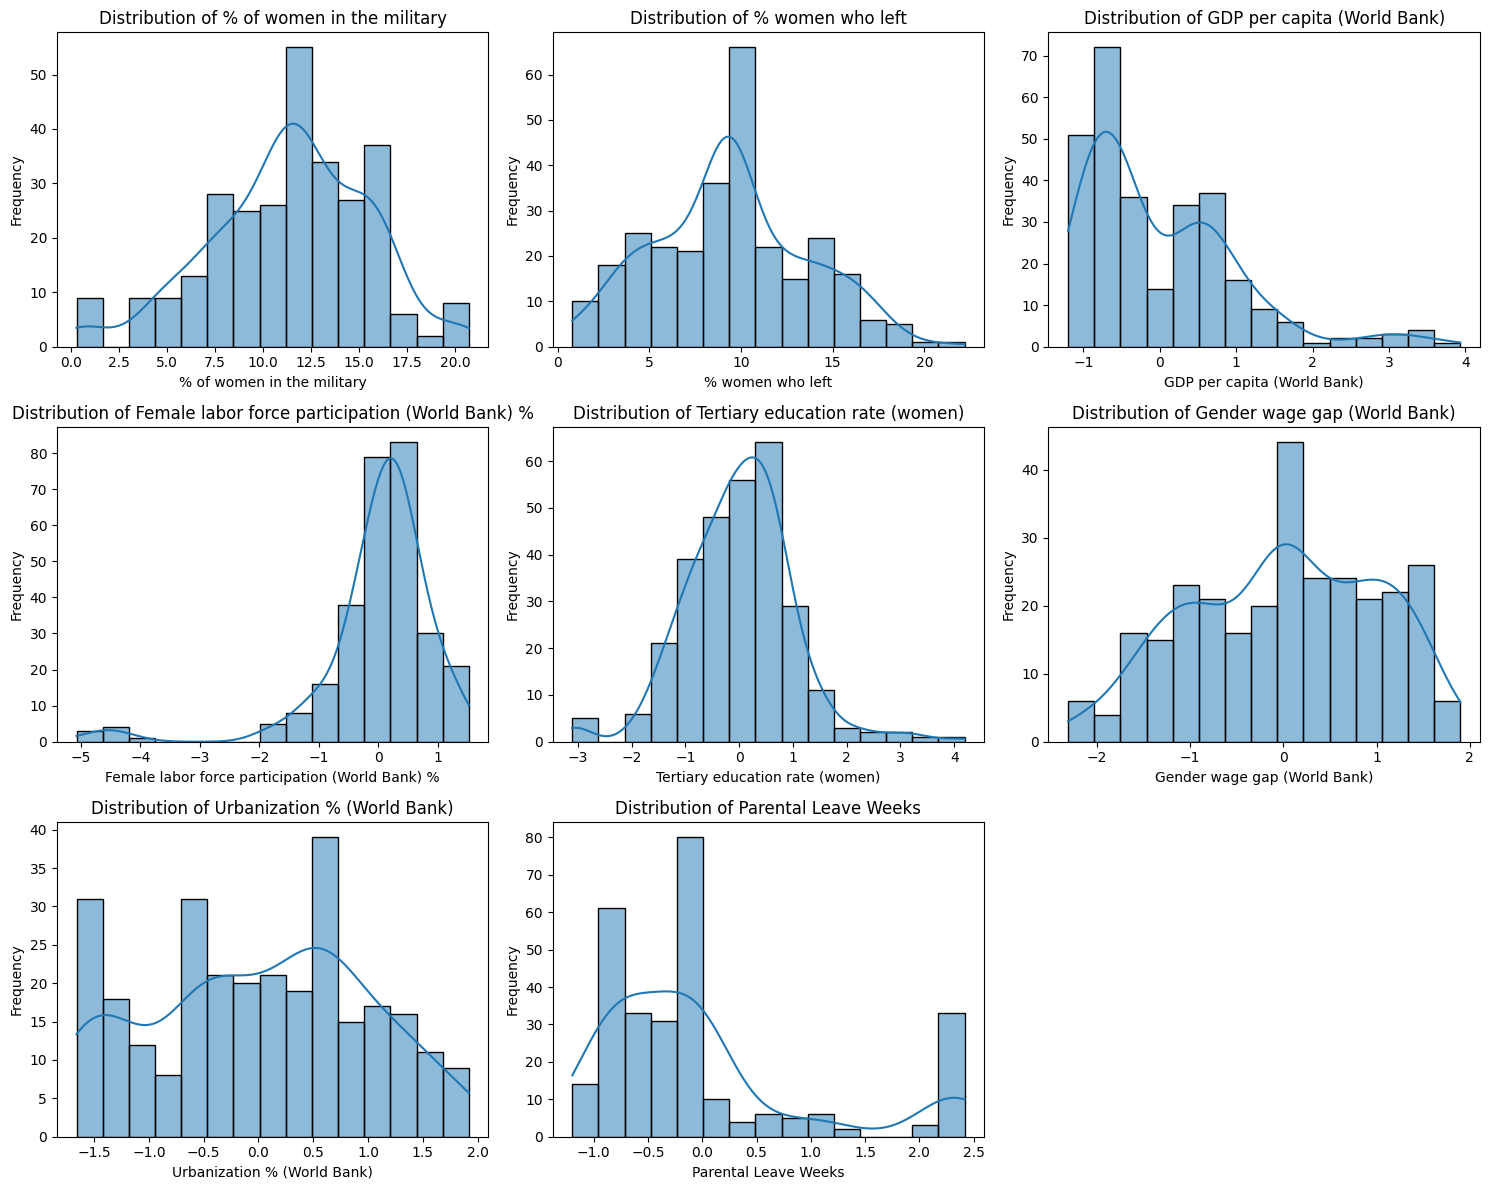


--- 3. Scatter Plots (DV vs. IVs) ---


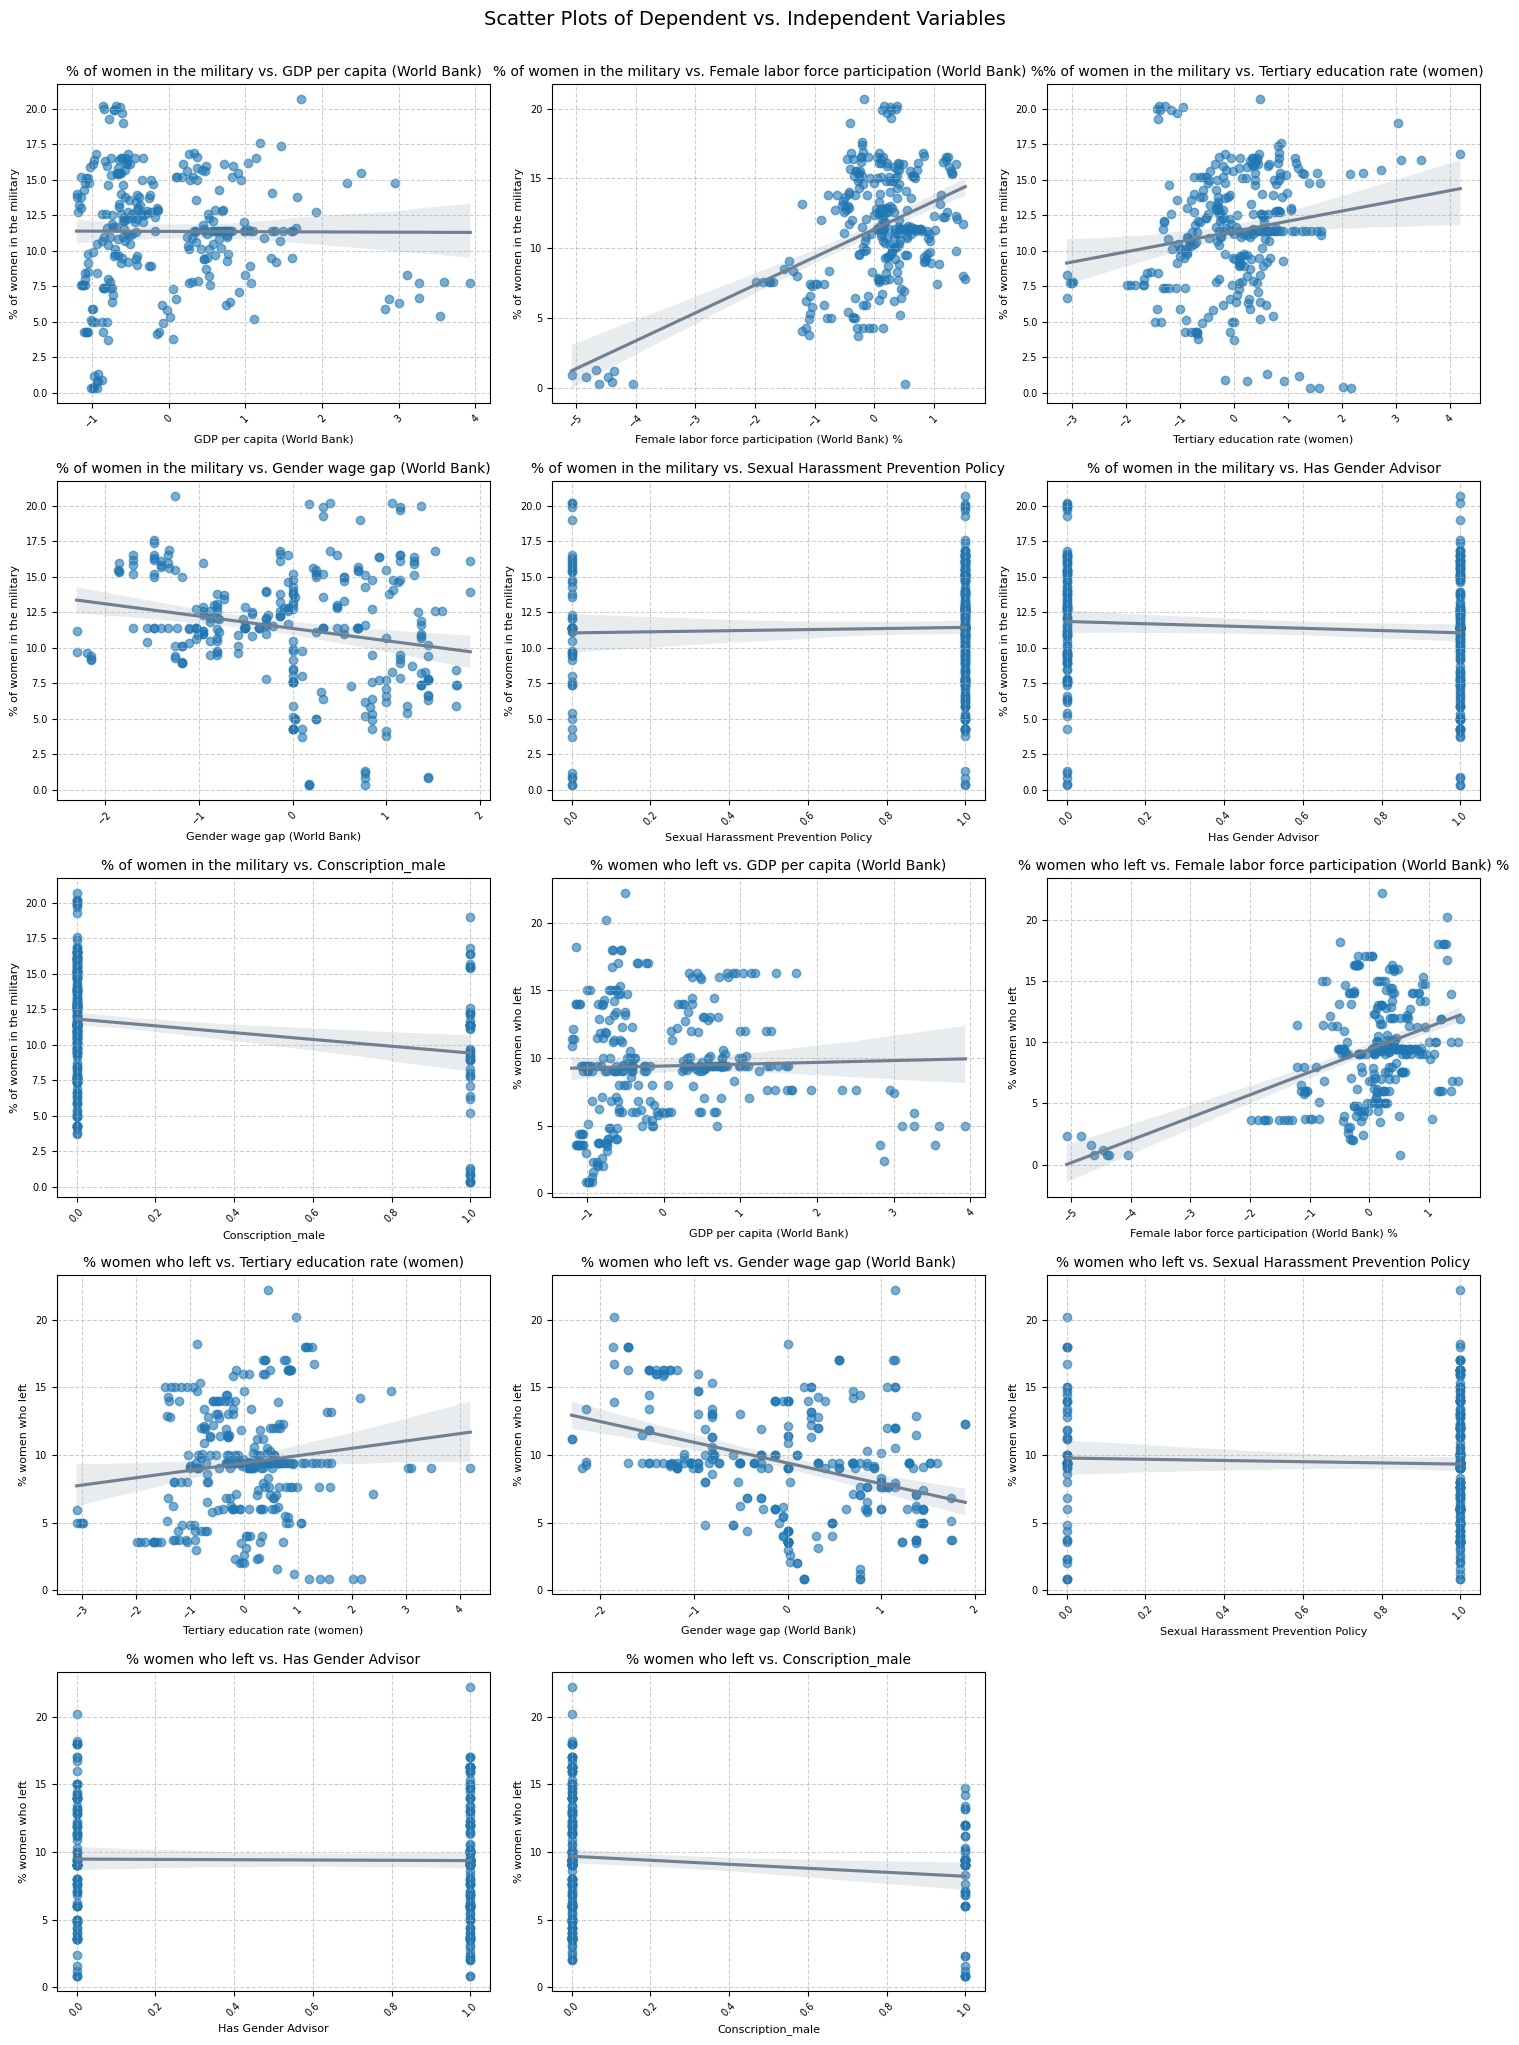


--- 4. Correlation Matrix ---


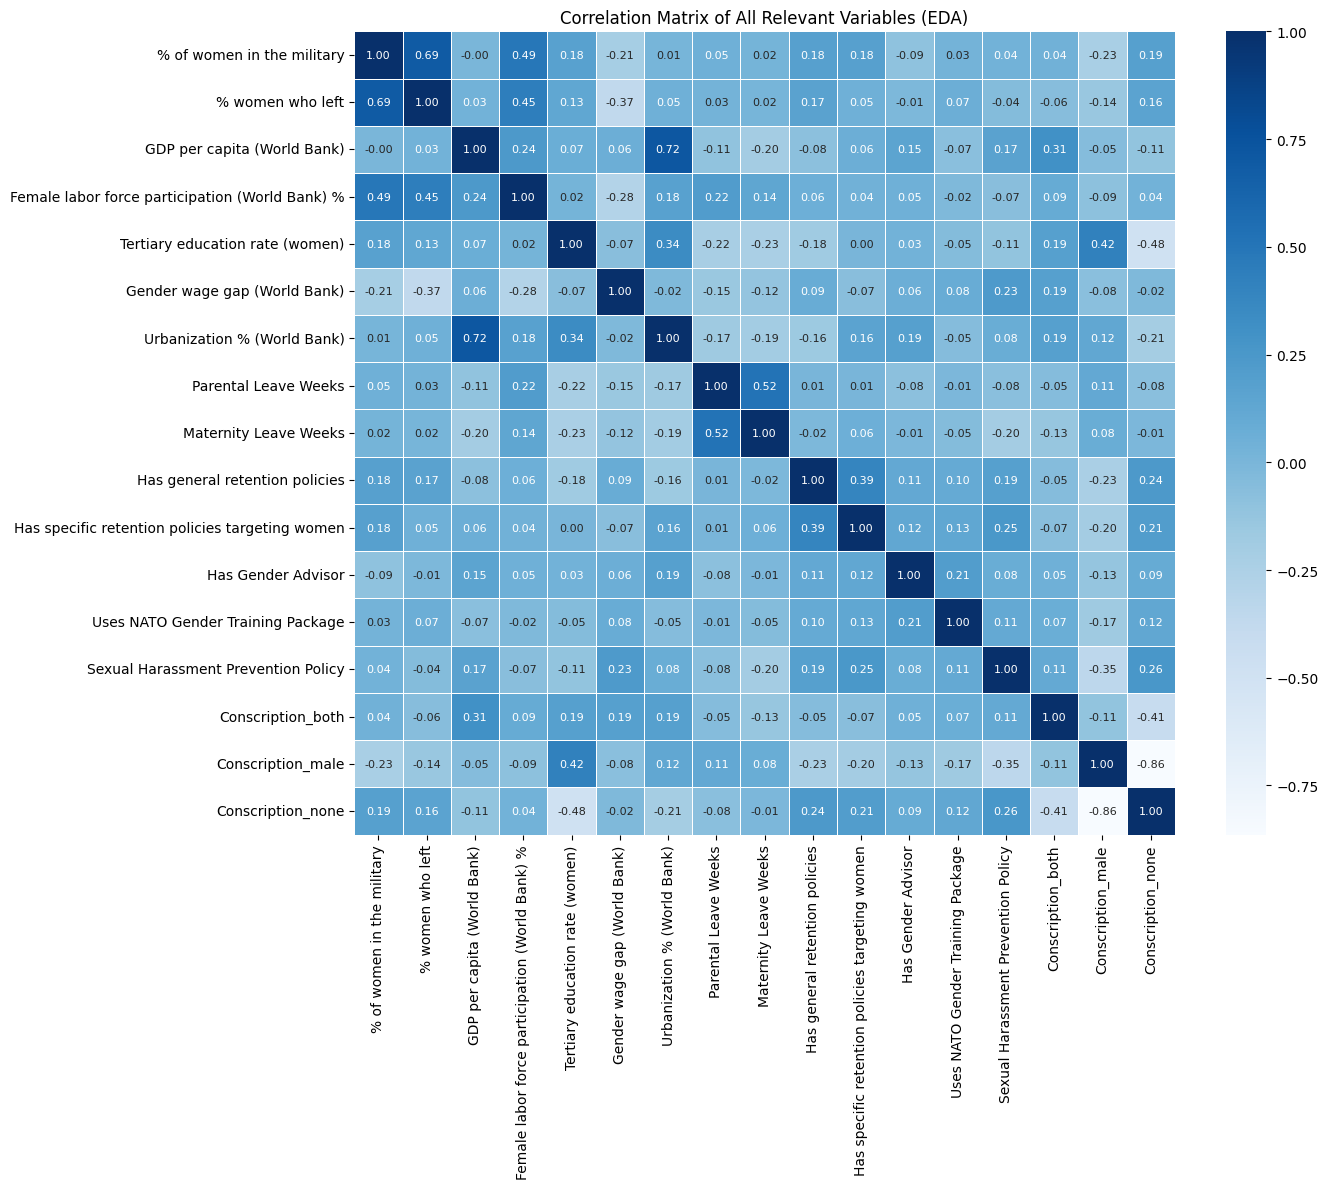


--- 5. Time Series Plots: Dependent Variables over Years per Country ---


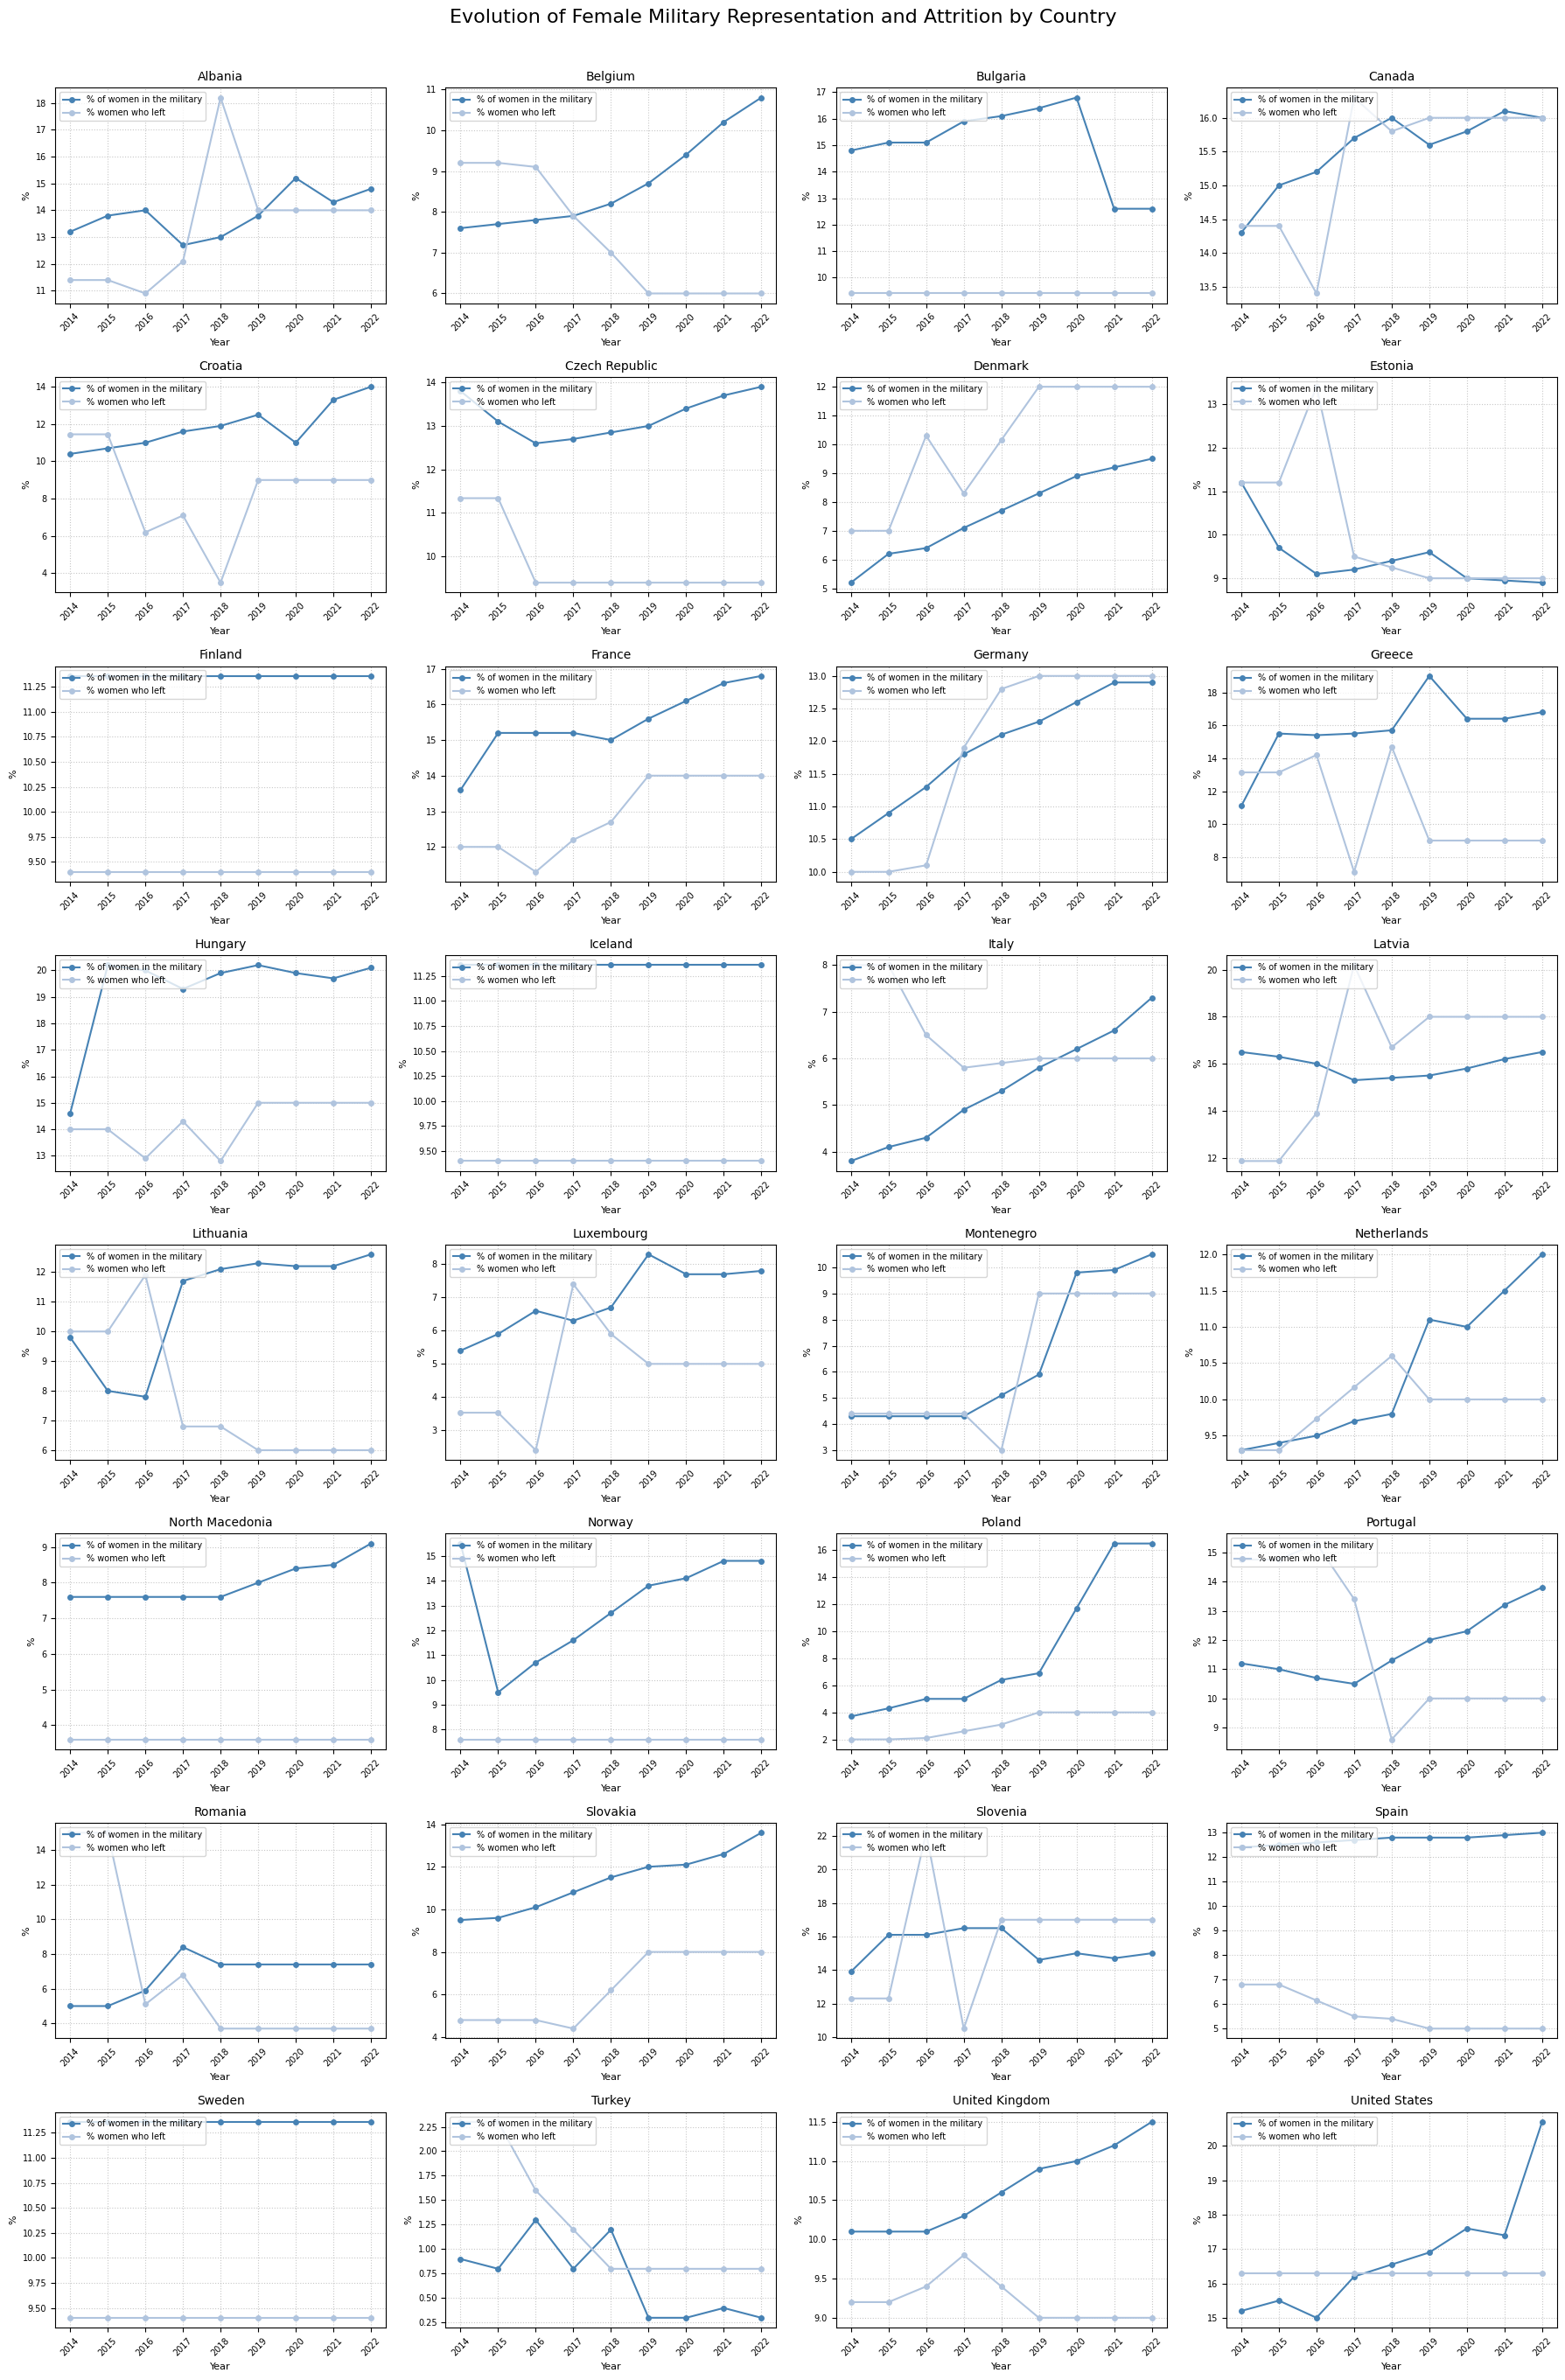

--- Exploratory Data Analysis (EDA) Complete ---


In [ ]:


print("--- Starting Exploratory Data Analysis (EDA) ---")

# identify numeric and categorical cols for EDA
numeric_cols = master_df.select_dtypes(include=np.number).columns.tolist()
if 'Year' in numeric_cols:
    numeric_cols.remove('Year')

categorical_cols = master_df.select_dtypes(include='object').columns.tolist()
if 'Country' in categorical_cols:
    categorical_cols.remove('Country')

binary_cols_for_eda = [
    'Part-time Employment Available',
    'Flexible Hours Available',
    'Has gender recruitment policy',
    'Has general retention policies',
    'Has specific retention policies targeting women',
    'Has Gender Advisor',
    'Uses NATO Gender Training Package',
    'Sexual Harassment Prevention Policy',
    'Sexual Abuse Prevention Policy',
    'Conscription_both',
    'Conscription_male',
    'Conscription_none'
]
binary_cols_for_eda = [col for col in binary_cols_for_eda if col in master_df.columns]

# 1. descriptive statistics
print("\n--- 1. Descriptive Statistics ---")
print("\nDescriptive statistics for numeric variables:")
display(master_df[numeric_cols].describe().T)

print("\nDescriptive statistics for categorical/binary variables (value counts):")
for col in categorical_cols + binary_cols_for_eda:
    if col in master_df.columns:
        print(f"\n--- {col} ---")
        display(master_df[col].value_counts(dropna=False))
        if master_df[col].isnull().any():
            print(f"Missing values for {col}: {master_df[col].isnull().sum()} ({master_df[col].isnull().mean()*100:.2f}%)")

# 2. histograms
print("\n--- 2. Histograms for Numeric Variables ---")
numeric_vars_for_hist = [
    '% of women in the military',
    '% women who left',
    'GDP per capita (World Bank)',
    'Female labor force participation (World Bank) %',
    'Tertiary education rate (women)',
    'Gender wage gap (World Bank)',
    'Urbanization % (World Bank)',
    'Parental Leave Weeks',
]
numeric_vars_for_hist = [col for col in numeric_vars_for_hist if col in master_df.columns]

if numeric_vars_for_hist:
    n_plots = len(numeric_vars_for_hist)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 5, n_rows * 4))
    for i, col in enumerate(numeric_vars_for_hist):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(master_df[col].dropna(), kde=True, bins=15)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
else:
    print("No numeric variables selected or found for histograms.")

# 3. scatter plots: DV vs IVs
print("\n--- 3. Scatter Plots (DV vs. IVs) ---")

dependent_variables = ['% of women in the military', '% women who left']
independent_variables_for_scatter = [
    'GDP per capita (World Bank)',
    'Female labor force participation (World Bank) %',
    'Tertiary education rate (women)',
    'Gender wage gap (World Bank)',
    'Sexual Harassment Prevention Policy',
    'Has Gender Advisor',
    'Conscription_male',
]

dependent_variables = [dv for dv in dependent_variables if dv in master_df.columns]
independent_variables_for_scatter = [iv for iv in independent_variables_for_scatter if iv in master_df.columns]

# generate scatter plots in grid layout
plots_to_create = [(dv, iv) for dv in dependent_variables for iv in independent_variables_for_scatter]
plots_to_create = [(dv, iv) for dv, iv in plots_to_create if not master_df[[dv, iv]].dropna().empty]

n_plots = len(plots_to_create)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for idx, (dv, iv) in enumerate(plots_to_create):
    plot_data = master_df[[dv, iv]].dropna()
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.regplot(x=iv, y=dv, data=plot_data,
                scatter_kws={'alpha': 0.6},
                line_kws={'color': 'slategrey'})
    plt.title(f'{dv} vs. {iv}', fontsize=10)
    plt.xlabel(iv, fontsize=8)
    plt.ylabel(dv, fontsize=8)
    plt.xticks(rotation=45, fontsize=7)
    plt.yticks(fontsize=7)
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.suptitle('Scatter Plots of Dependent vs. Independent Variables', fontsize=14, y=1.02)
plt.show()

# 4. correlation matrix
print("\n--- 4. Correlation Matrix ---")
correlation_vars_for_eda = [
    '% of women in the military',
    '% women who left',
    'GDP per capita (World Bank)',
    'Female labor force participation (World Bank) %',
    'Tertiary education rate (women)',
    'Gender wage gap (World Bank)',
    'Urbanization % (World Bank)',
    'Parental Leave Weeks',
    'Maternity Leave Weeks',
    'Has general retention policies',
    'Has specific retention policies targeting women',
    'Has Gender Advisor',
    'Uses NATO Gender Training Package',
    'Sexual Harassment Prevention Policy',
]
cons_cols_present_eda = [col for col in master_df.columns if col.startswith('Conscription_')]
for col in cons_cols_present_eda:
    if col not in correlation_vars_for_eda:
        correlation_vars_for_eda.append(col)
correlation_vars_for_eda = [col for col in correlation_vars_for_eda if col in master_df.columns]

if correlation_vars_for_eda:
    eda_correlation_matrix = master_df[correlation_vars_for_eda].corr()
    plt.figure(figsize=(14, 12))
    sns.heatmap(eda_correlation_matrix, annot=True, cmap='Blues', fmt=".2f",
                linewidths=.5, annot_kws={"size": 8})
    plt.title('Correlation Matrix of All Relevant Variables (EDA)')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("No relevant variables found for correlation matrix in EDA.")

# 5. time series plots separately for each country
print("\n--- 5. Time Series Plots: Dependent Variables over Years per Country ---")
dependent_vars_for_time_series = ['% of women in the military', '% women who left']
dependent_vars_for_time_series = [col for col in dependent_vars_for_time_series if col in master_df.columns]

if 'Year' not in master_df.columns:
    print("Error: 'Year' column not found in master_df. Cannot generate time series plots.")
    dependent_vars_for_time_series = []

if dependent_vars_for_time_series:
    unique_countries = master_df['Country'].unique()
    n_countries = len(unique_countries)
    n_cols_grid = 4
    n_rows_grid = (n_countries + n_cols_grid - 1) // n_cols_grid

    plt.figure(figsize=(n_cols_grid * 4.5, n_rows_grid * 3.5))
    for i, country in enumerate(unique_countries):
        ax = plt.subplot(n_rows_grid, n_cols_grid, i + 1)
        country_data = master_df[master_df['Country'] == country].sort_values('Year')

        for j, dv in enumerate(dependent_vars_for_time_series):
            plot_data_dv = country_data[['Year', dv]].dropna()
            if not plot_data_dv.empty:
                ax.plot(plot_data_dv['Year'], plot_data_dv[dv],
                        marker='o', linestyle='-', markersize=4,
                        label=dv,
                        color=['steelblue', 'lightsteelblue'][j])
            else:
                print(f"No data to plot for {dv} in {country}")

        ax.set_title(f'{country}', fontsize=10)
        ax.set_xlabel('Year', fontsize=8)
        ax.set_ylabel('%', fontsize=8)
        ax.tick_params(axis='x', rotation=45, labelsize=7)
        ax.tick_params(axis='y', labelsize=7)
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(fontsize=7, loc='upper left')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.suptitle('Evolution of Female Military Representation and Attrition by Country', fontsize=16, y=1.0)
    plt.show()
else:
    print("Dependent variables or 'Year' column not found for time series plots.")

print("--- Exploratory Data Analysis (EDA) Complete ---")



##Regressions

In [ ]:
!pip install linearmodels

Recruitment

Set 'Country' and 'Year' as MultiIndex for recruitment panel.
Dropped dummy variable: Conscription_none to avoid multicollinearity.

Independent variables selected for recruitment regression:
['Flexible Hours Available', 'Female labor force participation (World Bank) %', 'Gender wage gap (World Bank)', 'GDP per capita (World Bank)', 'Part-time Employment Available', 'Sexual Harassment Prevention Policy', 'Tertiary education rate (women)', 'Urbanization % (World Bank)', '% women in OF-6+', 'Conscription_both', 'Conscription_male']

No missing values found in the selected model variables.

--- Performing Breusch-Pagan LM test for panel effects (Pooled OLS vs RE) ---

Data types of exogenous variables for Breusch-Pagan test (after explicit float conversion):
const                                              float64
Flexible Hours Available                           float64
Female labor force participation (World Bank) %    float64
Gender wage gap (World Bank)                       float6

/tmp/ipython-input-7-3750459251.py:217: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y=coef_df_sorted.index, data=coef_df_sorted,


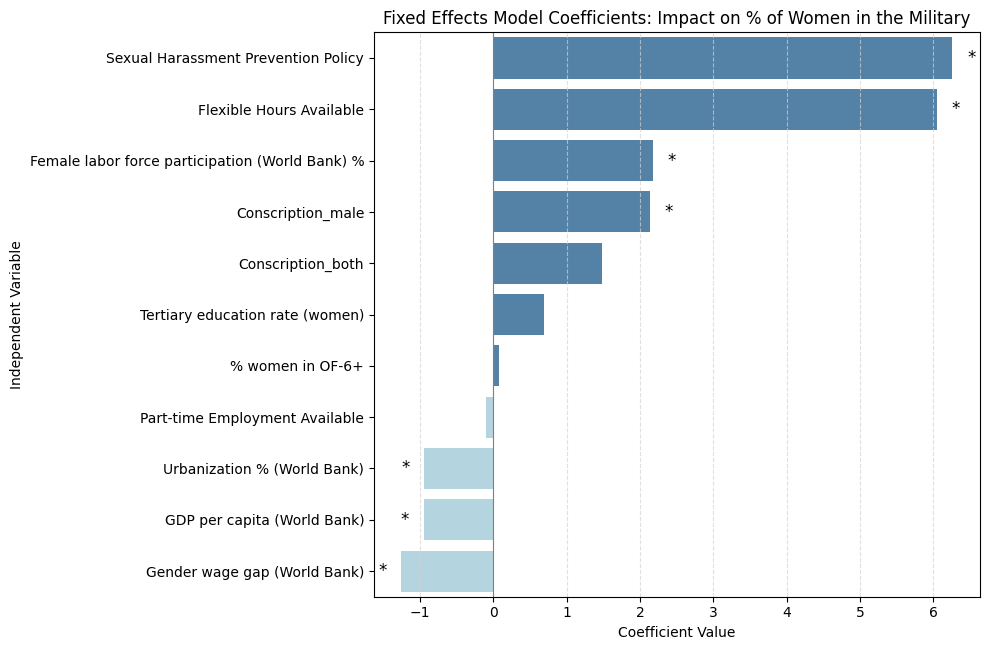

In [ ]:
##Regressions


# Prepare the recruitment panel dataset for linearmodels

rec_dv = '% of women in the military' # dependent variable

if not isinstance(recruitment_df.index, pd.MultiIndex) or recruitment_df.index.names != ['Country', 'Year']:
    if 'Country' in recruitment_df.columns and 'Year' in recruitment_df.columns:
        rec_panel = recruitment_df.set_index(['Country', 'Year'])
        print("Set 'Country' and 'Year' as MultiIndex for recruitment panel.")
    else:
        print("Error: 'Country' and 'Year' columns not found in recruitment_df. Cannot set MultiIndex.")
        print("Please ensure 'Country' and 'Year' columns exist in recruitment_df.")
        raise ValueError("Required columns not found in recruitment_df.")
else:
    rec_panel = recruitment_df


# 3) define independent variable sets
# based on the theoretical considerations for recruitment: demographic, economic, and specific policies indicated in the literature
independent_variables_list = [
    'Flexible Hours Available',
    'Female labor force participation (World Bank) %',
    'Gender wage gap (World Bank)',
    'GDP per capita (World Bank)',
    'Part-time Employment Available',
    'Sexual Harassment Prevention Policy',
    'Tertiary education rate (women)',
    'Urbanization % (World Bank)',
    '% women in OF-6+',

]

# add conscription dummies, dropping one to avoid perfect collinearity
cons_cols = [col for col in rec_panel.columns if col.startswith('Conscription_')]
dummy_to_drop = 'Conscription_none' # assuming 'none' is the base category to drop

cons_dummies_for_model = [col for col in cons_cols if col != dummy_to_drop]

if dummy_to_drop in cons_cols:
    print(f"Dropped dummy variable: {dummy_to_drop} to avoid multicollinearity.")
elif cons_cols:
    if len(cons_cols) > 1:

        dummy_to_drop_fallback = cons_cols[0]
        cons_dummies_for_model = [col for col in cons_cols if col != dummy_to_drop_fallback]
        print(f"Warning: '{dummy_to_drop}' not found. Dropping fallback dummy variable: {dummy_to_drop_fallback} instead.")
    else:
        cons_dummies_for_model = cons_cols # Keep it as is (if only one, it's not collinear)
        print("Not enough conscription dummies to drop one for multicollinearity.")
else:
    print("Warning: No 'Conscription_' dummy columns found in the panel data.")


independent_variables = independent_variables_list + cons_dummies_for_model


independent_variables = [col for col in independent_variables if col in rec_panel.columns]
if not independent_variables:
    print("Error: No valid independent variables found in the recruitment panel data.")
    raise ValueError("No valid independent variables found.")
else:
    print("\nIndependent variables selected for recruitment regression:")
    print(independent_variables)

X = rec_panel[independent_variables]

y = rec_panel[rec_dv]

# report any remaining NaNs in the selected variables before fitting

model_vars = independent_variables + [rec_dv]

model_vars_present = [col for col in model_vars if col in rec_panel.columns]

rows_with_nan_in_model_vars = rec_panel[model_vars_present].isnull().any(axis=1).sum()

if rows_with_nan_in_model_vars > 0:
    # calculate the number of complete cases for the selected model variables
    complete_cases = len(rec_panel[model_vars_present].dropna(how='any'))
    print(f"\nWarning: {rows_with_nan_in_model_vars} rows contain missing values in the selected model variables ({complete_cases} complete cases).")
    print("These rows will be dropped by linearmodels before fitting.")
    print("Missing values per variable in selected columns:")
    print(rec_panel[model_vars_present].isnull().sum()[rec_panel[model_vars_present].isnull().sum() > 0])
else:
    print("\nNo missing values found in the selected model variables.")


#Regression Analysis and Model Selection Tests

# Step 1: perform Breusch-Pagan LM test to check for panel effects (Pooled OLS vs. Random Effects)
# H0: No significant panel effects (Pooled OLS is chosen)
# H1: Significant panel effects (Random Effects is chosen)

print("\n--- Performing Breusch-Pagan LM test for panel effects (Pooled OLS vs RE) ---")
try:

    # select only the independent variables needed for the test
    X_for_bp = rec_panel[independent_variables].copy()

    for col in X_for_bp.columns:
        X_for_bp[col] = X_for_bp[col].astype(float)

    X_sm = sm.add_constant(X_for_bp)

    print("\nData types of exogenous variables for Breusch-Pagan test (after explicit float conversion):")
    print(X_sm.dtypes)

    # fit Pooled OLS model using statsmodels
    sm_pooled_model = sm.OLS(y, X_sm, missing='drop')
    sm_pooled_results = sm_pooled_model.fit()

    # perform the Breusch-Pagan test on the residuals of the statsmodels OLS model
    # The test checks for heteroscedasticity
    lm_statistic, lm_pvalue, f_statistic, f_pvalue = het_breuschpagan(sm_pooled_results.resid, sm_pooled_results.model.exog)

    print(f"Breusch-Pagan LM Statistic: {lm_statistic:.4f}")
    print(f"Breusch-Pagan LM p-value: {lm_pvalue:.4f}")
    # a significant p-value (< 0.05) suggests rejecting the null hypothesis of no panel effects

    if lm_pvalue < 0.05: # Using 0.05 as the significance level
        print("\nBreusch-Pagan test is significant (p < 0.05). Evidence of panel effects. Proceeding to Hausman test (for informational purposes).")
        perform_hausman_test = True
    else:
        print("\nBreusch-Pagan test is not significant (p >= 0.05). Pooled OLS might be appropriate. Hausman test will still be attempted (for informational purposes).")
        perform_hausman_test = True # still attempt Hausman for completeness, but BP is the primary indicator here


except Exception as e:
    print(f"\nCould not perform Breusch-Pagan test. Error: {e}")
    # if BP test fails, default to performing Hausman test for informational purposes
    print("Proceeding to Hausman test (for informational purposes) despite BP test failure.")
    perform_hausman_test = True

#THIS PART THROWS AN ERROR
# Step 2: perform Hausman test and fit Fixed Effects model
if perform_hausman_test:
    print("\n--- Performing Hausman Test (FE vs RE) (for informational purposes) ---")
    # fit Fixed Effects model using linearmodels
    try:
        fe_model = PanelOLS(y, X).fit()
        print("\nFixed Effects Model Summary:")
        print(fe_model)

        # fit Random Effects model using linearmodels
        random_model = RandomEffects(y, X).fit()
        print("\nRandom Effects Model Summary:")
        print(random_model)

        try:
            hausman_test_result = fe_model.compare(random_model)
            print("\nHausman Test Results (using linearmodels.compare):")
            print(hausman_test_result)
            # Interpretation of this test would typically guide model choice,
            # but based on BP test and observed differences, Fixed Effects is chosen

        except AttributeError as ae:
            print(f"\nlinearmodels.compare() failed with AttributeError: {ae}")
            print("Could not perform Hausman test using linearmodels' built-in method.")

        except Exception as general_e:
            print(f"\nAn unexpected error occurred during initial Hausman attempt. Error: {general_e}")
            print("Could not perform Hausman test using linearmodels' built-in method.")


    except Exception as fe_re_fit_error:
        print(f"\nAn error occurred while fitting FE or RE models. Error: {fe_re_fit_error}")
        print("\nCould not fit FE or RE models. Falling back to Pooled OLS results.")
        try:
            final_model_results = PooledOLS(y, X).fit()
            print("\n--- Final Chosen Model Summary (Pooled OLS Fallback) ---")
            print(final_model_results)
        except Exception as pooled_e:
            print(f"\nCould not fit Pooled OLS fallback. Error: {pooled_e}")


    # This line is executed if FE model fitting was successful
    try:
        final_model_results = fe_model
        print("\n--- Final Chosen Model Summary (Fixed Effects) ---")
        print(final_model_results)
    except NameError:
        print("\nFixed Effects model could not be fitted. No final model summary to display.")


else:

    print("\n--- Pooled OLS Model Summary (Suggested by Breusch-Pagan test) ---")
    try:
        final_model_results = PooledOLS(y, X).fit()
        print(final_model_results)
    except Exception as pooled_e:
        print(f"\nCould not fit Pooled OLS model. Error: {pooled_e}")


# Coefficient graph
print("\n--- Visualizing Fixed Effects Model Coefficients ---")

if 'fe_model' in locals() and fe_model is not None:
    # extract coefficients and p-values
    coefficients = fe_model.params.drop('Intercept', errors='ignore')
    p_values = fe_model.pvalues.drop('Intercept', errors='ignore')
    std_errs = fe_model.std_errors.drop('Intercept', errors='ignore')

    # Create a DataFrame
    coef_df = pd.DataFrame({
        'Coefficient': coefficients,
        'P-value': p_values,
        'Std. Err.': std_errs
    })

    # sort coefficients by magnitude
    coef_df_sorted = coef_df.sort_values(by='Coefficient', ascending=False)

    plt.figure(figsize=(10, len(coef_df_sorted) * 0.6))
    sns.barplot(x='Coefficient', y=coef_df_sorted.index, data=coef_df_sorted,
                palette=['steelblue' if c > 0 else 'lightblue' for c in coef_df_sorted['Coefficient']]) #

    # add stars for significance
    for i, (index, row) in enumerate(coef_df_sorted.iterrows()):
        if row['P-value'] < 0.05:

            x_val = row['Coefficient']
            y_val = i

            text_x_offset = 0.2 if x_val >= 0 else -0.2
            text_alignment = 'left' if x_val >= 0 else 'right'

            plt.text(x_val + text_x_offset, y_val, '*',
                     color='black', ha=text_alignment, va='center', fontsize=12)

    plt.xlabel('Coefficient Value')
    plt.ylabel('Independent Variable')
    plt.title('Fixed Effects Model Coefficients: Impact on % of Women in the Military')

    plt.grid(axis='x', linestyle='--', alpha=0.7, color='lightgrey')
    plt.axvline(0, color='grey', linestyle='-', linewidth=0.8) # Line at zero


    plt.tight_layout()
    plt.show()




Set 'Country' and 'Year' as MultiIndex for retention panel.
Dropped dummy variable: Conscription_none to serve as baseline and avoid multicollinearity.

Initial independent variables considered for retention regression:
['Female labor force participation (World Bank) %', 'Flexible Hours Available', 'GDP per capita (World Bank)', 'Gender wage gap (World Bank)', 'Has Gender Advisor', 'Has general retention policies', 'Has specific retention policies targeting women', 'Parental Leave Weeks', 'Part-time Employment Available', 'Sexual Harassment Prevention Policy', 'Uses NATO Gender Training Package', 'Conscription_both', 'Conscription_male']

No variables found to be constant in the effective sample.

Independent variables for Pooled OLS and Random Effects (after removing constant variables):
['Female labor force participation (World Bank) %', 'Flexible Hours Available', 'GDP per capita (World Bank)', 'Gender wage gap (World Bank)', 'Has Gender Advisor', 'Has general retention policies', '

/tmp/ipython-input-8-2438053528.py:195: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars_ret = sns.barplot(x='Coefficient', y=coef_df_ret_sorted.index, data=coef_df_ret_sorted,


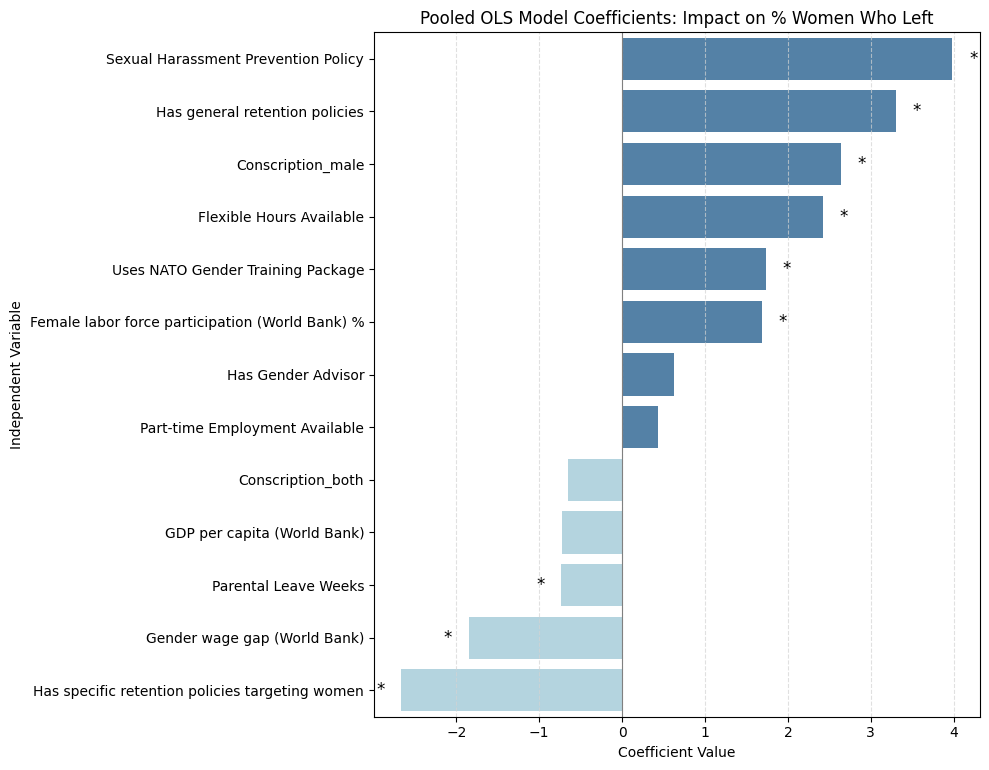

In [ ]:
##Final - Retention model


ret_dv = '% women who left' # dependent variable for retention

if not isinstance(retention_df.index, pd.MultiIndex) or retention_df.index.names != ['Country', 'Year']:
    if 'Country' in retention_df.columns and 'Year' in retention_df.columns:
        ret_panel = retention_df.set_index(['Country', 'Year'])
        print("Set 'Country' and 'Year' as MultiIndex for retention panel.")
    else:
        print("Error: 'Country' and 'Year' columns not found in retention_df. Cannot set MultiIndex.")
        print("Please ensure 'Country' and 'Year' columns exist in retention_df.")
        raise ValueError("Required columns not found in retention_df.")
else:
    ret_panel = retention_df


# 1) define initial independent variable set

initial_independent_variables = [
    'Female labor force participation (World Bank) %',
    'Flexible Hours Available',
    'GDP per capita (World Bank)',
    'Gender wage gap (World Bank)',
    'Has Gender Advisor',
    'Has general retention policies',
    'Has specific retention policies targeting women',
    'Parental Leave Weeks',
    'Part-time Employment Available',
    'Sexual Harassment Prevention Policy',
    'Uses NATO Gender Training Package',



]

# CORRECTED LOGIC FOR HANDLING CONSCRIPTION DUMMIES (forgot to drop initially which made the R2 so low)
all_cons_dummies = [col for col in ret_panel.columns if col.startswith('Conscription_')]
dummy_to_drop_for_baseline = 'Conscription_none' # explicitly define the baseline to drop

cons_dummies_for_model = []
if all_cons_dummies:
    if dummy_to_drop_for_baseline in all_cons_dummies:
#same code as for recruitment
        cons_dummies_for_model = [d for d in all_cons_dummies if d != dummy_to_drop_for_baseline]
        print(f"Dropped dummy variable: {dummy_to_drop_for_baseline} to serve as baseline and avoid multicollinearity.")
    else:
        print(f"Warning: '{dummy_to_drop_for_baseline}' not found. Cannot set specific baseline.")

        if len(all_cons_dummies) > 1:
            cons_dummies_for_model = all_cons_dummies[1:]
            print(f"Dropping fallback dummy variable: {all_cons_dummies[0]} instead for multicollinearity.")
        else:
            cons_dummies_for_model = all_cons_dummies
            print("Not enough conscription dummies to drop one for multicollinearity.")
else:
    print("Warning: No 'Conscription_' dummy columns found in the panel data for retention.")

initial_independent_variables.extend(cons_dummies_for_model)

initial_independent_variables = [col for col in initial_independent_variables if col in ret_panel.columns]

if not initial_independent_variables:
    print("Error: No valid independent variables found in the retention panel data.")
    raise ValueError("No valid independent variables found.")
else:
    print("\nInitial independent variables considered for retention regression:")
    print(initial_independent_variables)

# 2) prepare data for linearmodels
X = ret_panel[initial_independent_variables]
y = ret_panel[ret_dv]

data_for_fitting = pd.concat([y, X], axis=1).dropna(how='any')

if data_for_fitting.empty:
    print("\nError: No complete cases found after dropping missing values in selected variables.")
    raise ValueError("No complete cases for model fitting.")

# separate y and X for the effective sample
y_clean = data_for_fitting[ret_dv]
X_clean = data_for_fitting[initial_independent_variables]


# Identify variables that are constant in this effective sample (X_clean)
# these cause perfect multicollinearity with the intercept for ALL models
constant_vars_in_sample = X_clean.columns[X_clean.nunique() == 1].tolist()

if constant_vars_in_sample:
    print(f"\nWarning: The following variables are constant in the effective sample ({len(data_for_fitting)} complete cases) and will cause perfect multicollinearity with the intercept:")
    print(constant_vars_in_sample)
    print("These variables will be removed from the independent variables list for ALL models.")
    #  list of independent variables to exclude
    independent_variables_filtered = [col for col in initial_independent_variables if col not in constant_vars_in_sample]
else:
    print("\nNo variables found to be constant in the effective sample.")
    independent_variables_filtered = initial_independent_variables

final_independent_variables_pooled_re = independent_variables_filtered
print("\nIndependent variables for Pooled OLS and Random Effects (after removing constant variables):")
print(final_independent_variables_pooled_re)


#Check remaining NaNs
print(f"\nUsing {len(data_for_fitting)} complete cases for model fitting.")
cols_to_check_nan = [ret_dv] + final_independent_variables_pooled_re
cols_to_check_nan = [col for col in cols_to_check_nan if col in data_for_fitting.columns]

print("Missing values per variable in selected columns from the effective sample (should all be 0):")
print(data_for_fitting[cols_to_check_nan].isnull().sum())


# Regression Analysis and Model Selection Tests - same logic as recruitment model

# Step 1: Perform Breusch-Pagan LM test to check for panel effects (Pooled OLS vs RE)
# H0: No significant panel effects (Pooled OLS is appropriate)
# H1: Significant panel effects (RE is more appropriate)

print("\n--- Performing Breusch-Pagan LM test for panel effects (Pooled OLS vs RE) ---")
try:
    X_for_bp = X_clean[final_independent_variables_pooled_re].copy()

    for col in X_for_bp.columns:
        X_for_bp[col] = X_for_bp[col].astype(float)

    X_sm = sm.add_constant(X_for_bp)

    print("\nData types of exogenous variables for Breusch-Pagan test (after explicit float conversion):")
    print(X_sm.dtypes)

    sm_pooled_model = sm.OLS(y_clean, X_sm)
    sm_pooled_results = sm_pooled_model.fit()

    lm_statistic, lm_pvalue, f_statistic, f_pvalue = het_breuschpagan(sm_pooled_results.resid, sm_pooled_results.model.exog)

    print(f"Breusch-Pagan LM Statistic: {lm_statistic:.4f}")
    print(f"Breusch-Pagan LM p-value: {lm_pvalue:.4f}")

    if lm_pvalue < 0.05: # Using 0.05 as the significance level
        print("\nBreusch-Pagan test is significant (p < 0.05). Evidence of panel effects. Random Effects is likely more appropriate than Pooled OLS based on this test.")
    else:
        print("\nBreusch-Pagan test is not significant (p >= 0.05). Pooled OLS might be appropriate based on this test.")

except Exception as e:
    print(f"\nCould not perform Breusch-Pagan test. Error: {e}")


# Step 2: fit Pooled OLS and Random Effects using linearmodels
print("\n--- Fitting Panel Models using linearmodels ---")

try:
    pooled_model = PooledOLS(y_clean, X_clean[final_independent_variables_pooled_re]).fit()
    print("\nPooled OLS Model Summary:")
    print(pooled_model)
    final_model_results = pooled_model
except Exception as pooled_e:
    print(f"\nCould not fit Pooled OLS model. Error: {pooled_e}")
    final_model_results = None


try:
    random_model = RandomEffects(y_clean, X_clean[final_independent_variables_pooled_re]).fit()
    print("\nRandom Effects Model Summary:")
    print(random_model)
except Exception as random_e:
    print(f"\nCould not fit Random Effects model. Error: {random_e}")
    random_model = None


if final_model_results is not None:
    print("\n--- Final Chosen Model Summary (Pooled OLS) ---")
    print(final_model_results)
else:
    print("\n--- Pooled OLS Model could not be fitted. No final model summary to display. ---")
#graph
print("\n--- Visualizing Retention Model Coefficients ---")

if 'final_model_results' in locals() and final_model_results is not None:
    # extract coefficients and p-values
    coefficients_ret = final_model_results.params.drop('Intercept', errors='ignore')
    p_values_ret = final_model_results.pvalues.drop('Intercept', errors='ignore')
    std_errs_ret = final_model_results.std_errors.drop('Intercept', errors='ignore')

    # create a DataFrame
    coef_df_ret = pd.DataFrame({
        'Coefficient': coefficients_ret,
        'P-value': p_values_ret,
        'Std. Err.': std_errs_ret
    })

    # sort coefficients by magnitude
    coef_df_ret_sorted = coef_df_ret.sort_values(by='Coefficient', ascending=False)

    plt.figure(figsize=(10, len(coef_df_ret_sorted) * 0.6))
    bars_ret = sns.barplot(x='Coefficient', y=coef_df_ret_sorted.index, data=coef_df_ret_sorted,
                           palette=['steelblue' if c > 0 else 'lightblue' for c in coef_df_ret_sorted['Coefficient']]) # Consistent color palette

    # stars
    for i, (index, row) in enumerate(coef_df_ret_sorted.iterrows()):
        if row['P-value'] < 0.05:
            x_val = row['Coefficient']
            y_val = i
            text_x_offset = 0.2 if x_val >= 0 else -0.2
            text_alignment = 'left' if x_val >= 0 else 'right'
            plt.text(x_val + text_x_offset, y_val, '*',
                     color='black', ha=text_alignment, va='center', fontsize=12)

    plt.xlabel('Coefficient Value')
    plt.ylabel('Independent Variable')
    plt.title('Pooled OLS Model Coefficients: Impact on % Women Who Left')

    plt.grid(axis='x', linestyle='--', alpha=0.7, color='lightgrey')
    plt.axvline(0, color='grey', linestyle='-', linewidth=0.8) # Line at zero

    plt.tight_layout()
    plt.show()


else:
    print("\nBar graph could not be generated for retention model as the Pooled OLS model was not successfully fitted.")




Set 'Country' and 'Year' as MultiIndex for retention panel.
Dropped dummy variable: Conscription_none to serve as baseline and avoid multicollinearity.

Initial independent variables considered for retention regression:
['Female labor force participation (World Bank) %', 'Flexible Hours Available_lag1', 'GDP per capita (World Bank)', 'Gender wage gap (World Bank)', 'Has Gender Advisor_lag1', 'Has general retention policies_lag1', 'Has specific retention policies targeting women_lag1', 'Parental Leave Weeks_lag1', 'Part-time Employment Available_lag1', 'Sexual Harassment Prevention Policy_lag1', 'Uses NATO Gender Training Package_lag1', 'Conscription_both', 'Conscription_male']

No variables found to be constant in the effective sample.

Independent variables for Pooled OLS and Random Effects (after removing constant variables):
['Female labor force participation (World Bank) %', 'Flexible Hours Available_lag1', 'GDP per capita (World Bank)', 'Gender wage gap (World Bank)', 'Has Gender 

/tmp/ipython-input-9-2399419697.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars_ret = sns.barplot(x='Coefficient', y=coef_df_ret_sorted.index, data=coef_df_ret_sorted,


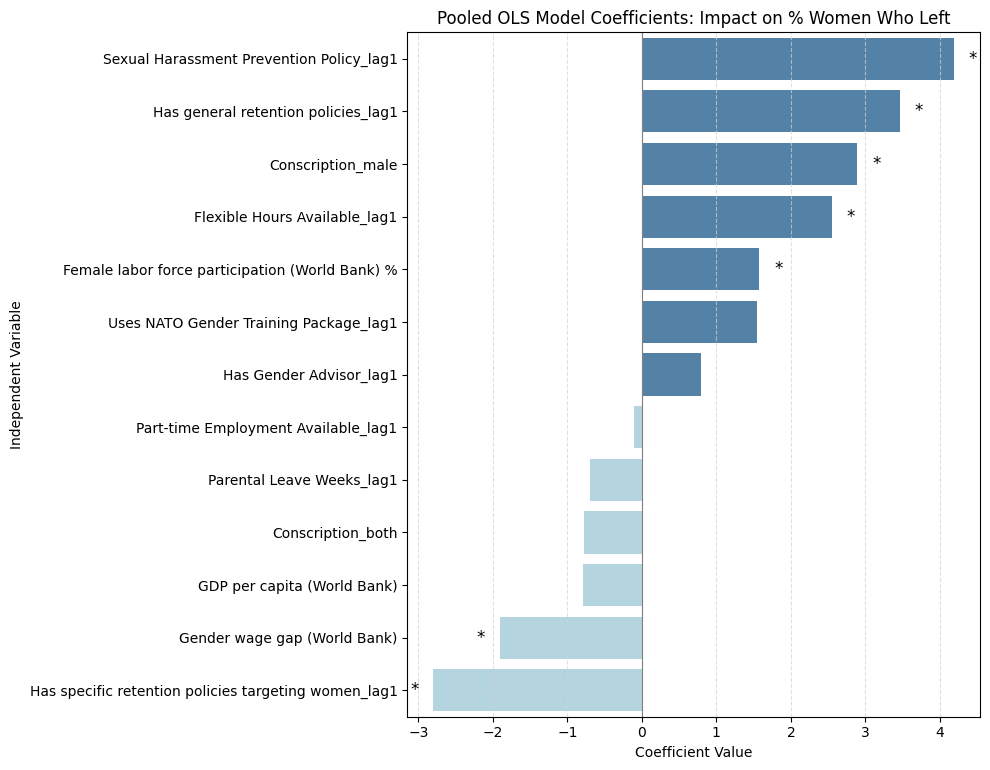

In [ ]:
##LAGGED EFFECTS
#exactly same code as previously just with lagged policy variables (by 1 year)


ret_dv = '% women who left'

if not isinstance(retention_df.index, pd.MultiIndex) or retention_df.index.names != ['Country', 'Year']:
    if 'Country' in retention_df.columns and 'Year' in retention_df.columns:
        ret_panel = retention_df.set_index(['Country', 'Year'])
        print("Set 'Country' and 'Year' as MultiIndex for retention panel.")
    else:
        print("Error: 'Country' and 'Year' columns not found in retention_df. Cannot set MultiIndex.")
        print("Please ensure 'Country' and 'Year' columns exist in retention_df.")
        raise ValueError("Required columns not found in retention_df.")
else:
    ret_panel = retention_df

initial_independent_variables = [
    'Female labor force participation (World Bank) %',
    'Flexible Hours Available_lag1',
    'GDP per capita (World Bank)',
    'Gender wage gap (World Bank)',
    'Has Gender Advisor_lag1',
    'Has general retention policies_lag1',
    'Has specific retention policies targeting women_lag1',
    'Parental Leave Weeks_lag1',
    'Part-time Employment Available_lag1',
    'Sexual Harassment Prevention Policy_lag1',
    'Uses NATO Gender Training Package_lag1',



]

all_cons_dummies = [col for col in ret_panel.columns if col.startswith('Conscription_')]
dummy_to_drop_for_baseline = 'Conscription_none'

cons_dummies_for_model = []
if all_cons_dummies:
    if dummy_to_drop_for_baseline in all_cons_dummies:

        cons_dummies_for_model = [d for d in all_cons_dummies if d != dummy_to_drop_for_baseline]
        print(f"Dropped dummy variable: {dummy_to_drop_for_baseline} to serve as baseline and avoid multicollinearity.")
    else:
        print(f"Warning: '{dummy_to_drop_for_baseline}' not found. Cannot set specific baseline.")

        if len(all_cons_dummies) > 1:
            cons_dummies_for_model = all_cons_dummies[1:]
            print(f"Dropping fallback dummy variable: {all_cons_dummies[0]} instead for multicollinearity.")
        else:
            cons_dummies_for_model = all_cons_dummies
            print("Not enough conscription dummies to drop one for multicollinearity.")
else:
    print("Warning: No 'Conscription_' dummy columns found in the panel data for retention.")


initial_independent_variables.extend(cons_dummies_for_model)

initial_independent_variables = [col for col in initial_independent_variables if col in ret_panel.columns]

if not initial_independent_variables:
    print("Error: No valid independent variables found in the retention panel data.")
    raise ValueError("No valid independent variables found.")
else:
    print("\nInitial independent variables considered for retention regression:")
    print(initial_independent_variables)

X = ret_panel[initial_independent_variables]
y = ret_panel[ret_dv]

data_for_fitting = pd.concat([y, X], axis=1).dropna(how='any')

if data_for_fitting.empty:
    print("\nError: No complete cases found after dropping missing values in selected variables.")
    raise ValueError("No complete cases for model fitting.")

y_clean = data_for_fitting[ret_dv]
X_clean = data_for_fitting[initial_independent_variables]

constant_vars_in_sample = X_clean.columns[X_clean.nunique() == 1].tolist()

if constant_vars_in_sample:
    print(f"\nWarning: The following variables are constant in the effective sample ({len(data_for_fitting)} complete cases) and will cause perfect multicollinearity with the intercept:")
    print(constant_vars_in_sample)
    print("These variables will be removed from the independent variables list for ALL models.")
    independent_variables_filtered = [col for col in initial_independent_variables if col not in constant_vars_in_sample]
else:
    print("\nNo variables found to be constant in the effective sample.")
    independent_variables_filtered = initial_independent_variables


final_independent_variables_pooled_re = independent_variables_filtered
print("\nIndependent variables for Pooled OLS and Random Effects (after removing constant variables):")
print(final_independent_variables_pooled_re)


print(f"\nUsing {len(data_for_fitting)} complete cases for model fitting.")
cols_to_check_nan = [ret_dv] + final_independent_variables_pooled_re
cols_to_check_nan = [col for col in cols_to_check_nan if col in data_for_fitting.columns]

print("Missing values per variable in selected columns from the effective sample (should all be 0):")
print(data_for_fitting[cols_to_check_nan].isnull().sum())


# Regression Analysis and Model Selection Tests


print("\n--- Performing Breusch-Pagan LM test for panel effects (Pooled OLS vs RE) ---")
try:
    X_for_bp = X_clean[final_independent_variables_pooled_re].copy()

    for col in X_for_bp.columns:
        X_for_bp[col] = X_for_bp[col].astype(float)

    X_sm = sm.add_constant(X_for_bp)

    print("\nData types of exogenous variables for Breusch-Pagan test (after explicit float conversion):")
    print(X_sm.dtypes)

    sm_pooled_model = sm.OLS(y_clean, X_sm)
    sm_pooled_results = sm_pooled_model.fit()

    lm_statistic, lm_pvalue, f_statistic, f_pvalue = het_breuschpagan(sm_pooled_results.resid, sm_pooled_results.model.exog)

    print(f"Breusch-Pagan LM Statistic: {lm_statistic:.4f}")
    print(f"Breusch-Pagan LM p-value: {lm_pvalue:.4f}")

    if lm_pvalue < 0.05:
        print("\nBreusch-Pagan test is significant (p < 0.05). Evidence of panel effects. Random Effects is likely more appropriate than Pooled OLS based on this test.")
    else:
        print("\nBreusch-Pagan test is not significant (p >= 0.05). Pooled OLS might be appropriate based on this test.")

except Exception as e:
    print(f"\nCould not perform Breusch-Pagan test. Error: {e}")


print("\n--- Fitting Panel Models using linearmodels ---")

try:
    pooled_model = PooledOLS(y_clean, X_clean[final_independent_variables_pooled_re]).fit()
    print("\nPooled OLS Model Summary:")
    print(pooled_model)
    final_model_results = pooled_model
except Exception as pooled_e:
    print(f"\nCould not fit Pooled OLS model. Error: {pooled_e}")
    final_model_results = None


try:
    random_model = RandomEffects(y_clean, X_clean[final_independent_variables_pooled_re]).fit()
    print("\nRandom Effects Model Summary:")
    print(random_model)
except Exception as random_e:
    print(f"\nCould not fit Random Effects model. Error: {random_e}")
    random_model = None


if final_model_results is not None:
    print("\n--- Final Chosen Model Summary (Pooled OLS) ---")
    print(final_model_results)
else:
    print("\n--- Pooled OLS Model could not be fitted. No final model summary to display. ---")

print("\n--- Visualizing Retention Model Coefficients ---")

if 'final_model_results' in locals() and final_model_results is not None:

    coefficients_ret = final_model_results.params.drop('Intercept', errors='ignore')
    p_values_ret = final_model_results.pvalues.drop('Intercept', errors='ignore')
    std_errs_ret = final_model_results.std_errors.drop('Intercept', errors='ignore')

    coef_df_ret = pd.DataFrame({
        'Coefficient': coefficients_ret,
        'P-value': p_values_ret,
        'Std. Err.': std_errs_ret
    })

    coef_df_ret_sorted = coef_df_ret.sort_values(by='Coefficient', ascending=False)

    plt.figure(figsize=(10, len(coef_df_ret_sorted) * 0.6))
    bars_ret = sns.barplot(x='Coefficient', y=coef_df_ret_sorted.index, data=coef_df_ret_sorted,
                           palette=['steelblue' if c > 0 else 'lightblue' for c in coef_df_ret_sorted['Coefficient']])

    for i, (index, row) in enumerate(coef_df_ret_sorted.iterrows()):
        if row['P-value'] < 0.05:
            x_val = row['Coefficient']
            y_val = i
            text_x_offset = 0.2 if x_val >= 0 else -0.2
            text_alignment = 'left' if x_val >= 0 else 'right'
            plt.text(x_val + text_x_offset, y_val, '*',
                     color='black', ha=text_alignment, va='center', fontsize=12)

    plt.xlabel('Coefficient Value')
    plt.ylabel('Independent Variable')
    plt.title('Pooled OLS Model Coefficients: Impact on % Women Who Left')

    plt.grid(axis='x', linestyle='--', alpha=0.7, color='lightgrey')
    plt.axvline(0, color='grey', linestyle='-', linewidth=0.8)



    plt.tight_layout()
    plt.show()


else:
    print("\nBar graph could not be generated for retention model as the Pooled OLS model was not successfully fitted.")



##Clustering


--- Creating 'Retention_Success_Score' for Clustering ---
Created 'Retention_Success_Score' (max attrition was 22.20%).
Higher score means lower attrition.
--- 'Retention_Success_Score' Creation Complete ---

--- Starting Two-Stage Comprehensive Country Clustering Analysis ---

Aggregating data to country level using mean for Stage 1 (DV) features: ['% of women in the military', 'Retention_Success_Score']

Using 2 DV features for Stage 1 clustering after checking presence:
['% of women in the military', 'Retention_Success_Score']

Prepared country-level data for Stage 1 clustering with 32 countries.
Sample of aggregated Stage 1 country-level DV data (head):
          % of women in the military  Retention_Success_Score
Country                                                      
Albania                    13.866667                 8.866667
Belgium                     8.700000                14.822222
Bulgaria                   15.044444                12.799246
Canada                 

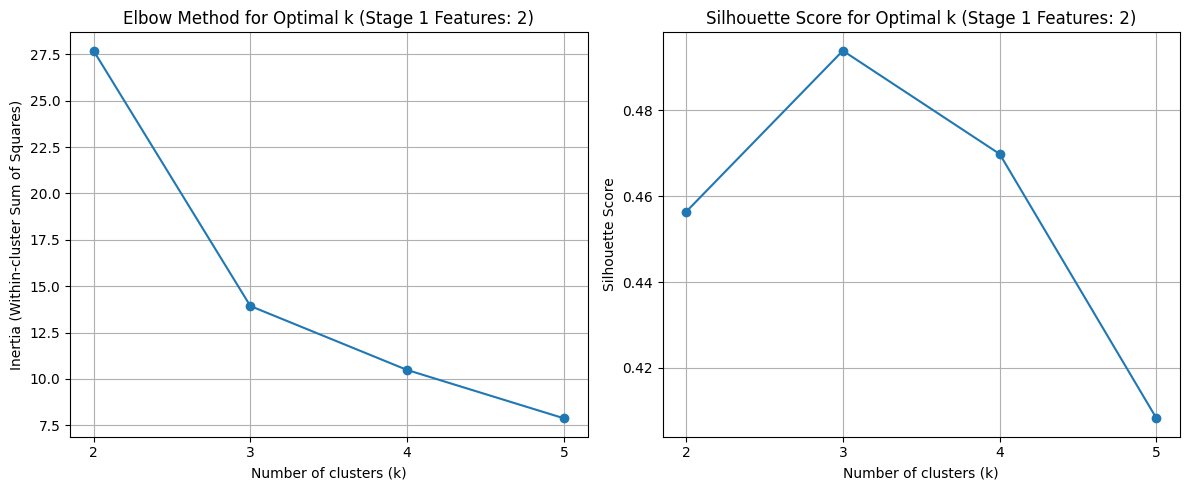


Review the Elbow and Silhouette plots to help choose the final number of clusters (N_CLUSTERS_FINAL).
Inertia values for k in [2, 3, 4, 5]: [27.7  13.93 10.48  7.87]
Silhouette scores for k in [2, 3, 4, 5]: [0.4563 0.4938 0.4698 0.4083]

Performing final K-Means clustering with N_CLUSTERS=3 using the selected Stage 1 (DV) features...
Stage 1 clustering complete. Cluster labels added to 'country_df_stage1_dvs'.

Average silhouette_score for Stage 1 with n_clusters = 3 is : 0.4938

--- Stage 2: Cluster Profiling ---

Profiling clusters based on 32 countries.

Number of countries per cluster:
Cluster
0     8
1     7
2    17
Name: count, dtype: int64

Countries in each cluster:
Cluster 0: ['Albania', 'Canada', 'France', 'Greece', 'Hungary', 'Latvia', 'Slovenia', 'United States']
Cluster 1: ['Italy', 'Luxembourg', 'Montenegro', 'North Macedonia', 'Poland', 'Romania', 'Turkey']
Cluster 2: ['Belgium', 'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'Germany', 'Icela

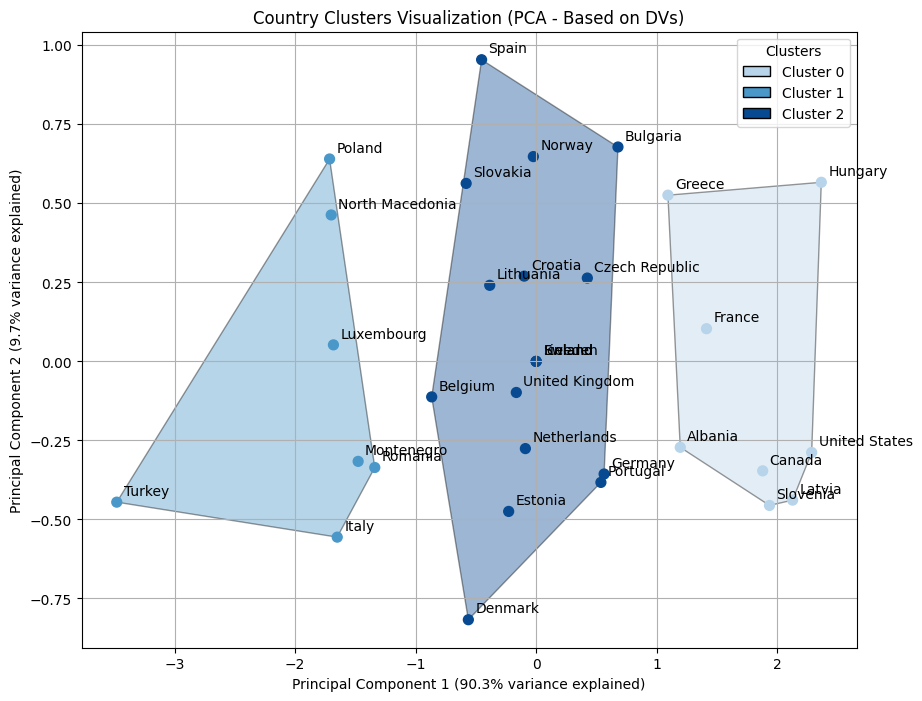


PCA explained variance ratio for each component: [0.9 0.1]
Total variance explained by first 2 components: 100.0%

--- Two-Stage Clustering Analysis Complete ---


In [ ]:
# PROBABLY FINAL CLUSTERING EXPERIMENT
# this variable will be used for clustering as a DV alongside '% of women in the military'
# Higher values indicate better retention (lower attrition)
print("\n--- Creating 'Retention_Success_Score' for Clustering ---")
if '% women who left' in master_df.columns:
    max_attrition_rate = master_df['% women who left'].max()
    master_df['Retention_Success_Score'] = max_attrition_rate - master_df['% women who left']
    print(f"Created 'Retention_Success_Score' (max attrition was {max_attrition_rate:.2f}%).")
    print("Higher score means lower attrition.")
else:
    print("'% women who left' column not found, cannot create 'Retention_Success_Score'.")
print("--- 'Retention_Success_Score' Creation Complete ---")

#  features for Stage 1 clustering (based on DVs)

CLUSTERING_FEATURES_STAGE1_DVS = [
    '% of women in the military',
    'Retention_Success_Score',
]

#  features for Stage 2 Profiling (the independent variables)
# These are the characteristics that will describe the  clusters
PROFILING_FEATURES_STAGE2_IVS = [
    # Key policy variables
    'Parental Leave Weeks',
    'Maternity Leave Weeks',
    'Sexual Harassment Prevention Policy',
    'Has general retention policies',
    'Has specific retention policies targeting women',
    'Has Gender Advisor',
    'Uses NATO Gender Training Package',
    'Flexible Hours Available',
    'Part-time Employment Available',

    # Key socioeconomic variables
    'GDP per capita (World Bank)',
    'Female labor force participation (World Bank) %',
    'Tertiary education rate (women)',
    'Gender wage gap (World Bank)',
    'Urbanization % (World Bank)',

    '% women in OF-6+',

    # Conscription Dummies (all three can be used just for profiling)
    'Conscription_both',
    'Conscription_male',
    'Conscription_none' # Include for profiling, even if base for regression
]

# all DVs for context in profiling (already unscaled in master_df)
DVS_FOR_FULL_PROFILING = [
    '% of women in the military',
    'Retention_Success_Score',
    '% women who left',
]


# Configuration
K_RANGE_EVAL = range(2, 6) # evaluate k from 2 to 5
N_CLUSTERS_FINAL = 3 # ADJUST BASED ON PLOTS!!
RANDOM_STATE = 42 # For reproducibility

print("\n--- Starting Two-Stage Comprehensive Country Clustering Analysis ---")

# 1. Prepare data for stage 1 clustering
# aggregate the master_df to the country level
print(f"\nAggregating data to country level using mean for Stage 1 (DV) features: {CLUSTERING_FEATURES_STAGE1_DVS}")

clustering_features_stage1_dvs_present = [col for col in CLUSTERING_FEATURES_STAGE1_DVS if col in master_df.columns]

if not clustering_features_stage1_dvs_present:
    print("Error: No relevant CLUSTERING_FEATURES_STAGE1_DVS found in master_df. Cannot perform clustering.")
else:
    print(f"\nUsing {len(clustering_features_stage1_dvs_present)} DV features for Stage 1 clustering after checking presence:")
    print(clustering_features_stage1_dvs_present)

    # aggregate means of DV features from master_df
    country_df_stage1_dvs = (
        master_df
        .groupby('Country')[clustering_features_stage1_dvs_present]
        .mean()
        .dropna() # Drop any countries with missing values
    )

    if country_df_stage1_dvs.empty:
        print("\nError: No countries remain after aggregating and dropping NaNs for Stage 1 (DVs). Cannot perform clustering.")
    else:
        print(f"\nPrepared country-level data for Stage 1 clustering with {len(country_df_stage1_dvs)} countries.")
        print("Sample of aggregated Stage 1 country-level DV data (head):")
        print(country_df_stage1_dvs.head())

        # 2. scaling the data

        print("\nScaling the aggregated Stage 1 (DV) country-level data for clustering...")
        scaler_stage1_dvs = StandardScaler()
        scaled_country_data_stage1_dvs = scaler_stage1_dvs.fit_transform(country_df_stage1_dvs)
        print("Stage 1 (DV) data scaled successfully for KMeans.")

        # 3. Determining the optimal number of clusters for Stage 1
        print(f"\nEvaluating cluster quality for k from {min(K_RANGE_EVAL)} to {max(K_RANGE_EVAL)} with the selected Stage 1 (DV) features...")
        inertia = []
        silhouette_scores = []

        actual_k_range = [k for k in K_RANGE_EVAL if k <= len(country_df_stage1_dvs)]

        if len(actual_k_range) > 0:
            for k in actual_k_range:
                kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
                kmeans.fit(scaled_country_data_stage1_dvs)
                inertia.append(kmeans.inertia_)
                if k >= 2:
                    score = silhouette_score(scaled_country_data_stage1_dvs, kmeans.labels_)
                    silhouette_scores.append(score)
                else:
                    silhouette_scores.append(np.nan)

            # Plot the Elbow Method graph
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(actual_k_range, inertia, marker='o')
            plt.xlabel('Number of clusters (k)')
            plt.ylabel('Inertia (Within-cluster Sum of Squares)')
            plt.title(f'Elbow Method for Optimal k (Stage 1 Features: {len(clustering_features_stage1_dvs_present)})')
            plt.xticks(actual_k_range)
            plt.grid(True)

            # Plot the Silhouette Score graph
            plt.subplot(1, 2, 2)
            valid_silhouette_k = [k for k in actual_k_range if k >= 2]
            valid_silhouette_scores = [score for score in silhouette_scores if not np.isnan(score)]

            if valid_silhouette_k:
                plt.plot(valid_silhouette_k, valid_silhouette_scores, marker='o')
                plt.xlabel('Number of clusters (k)')
                plt.ylabel('Silhouette Score')
                plt.title(f'Silhouette Score for Optimal k (Stage 1 Features: {len(clustering_features_stage1_dvs_present)})')
                plt.xticks(valid_silhouette_k)
                plt.grid(True)
            else:
                print("Not enough clusters (k>=2) to plot Silhouette scores.")

            plt.tight_layout()
            plt.show()

            print("\nReview the Elbow and Silhouette plots to help choose the final number of clusters (N_CLUSTERS_FINAL).")
            print(f"Inertia values for k in {list(actual_k_range)}: {np.round(inertia, 2)}")
            print(f"Silhouette scores for k in {list(valid_silhouette_k)}: {np.round(valid_silhouette_scores, 4)}")

        else:
            print("Not enough countries to explore multiple cluster numbers (need at least 2).")
            N_CLUSTERS_FINAL = min(len(country_df_stage1_dvs), 1)

        # 4. Perform final stage 1 clustering
        if len(country_df_stage1_dvs) >= N_CLUSTERS_FINAL and N_CLUSTERS_FINAL > 0:
            print(f"\nPerforming final K-Means clustering with N_CLUSTERS={N_CLUSTERS_FINAL} using the selected Stage 1 (DV) features...")
            kmeans_stage1 = KMeans(n_clusters=N_CLUSTERS_FINAL, random_state=RANDOM_STATE, n_init=10)
            country_df_stage1_dvs['Cluster'] = kmeans_stage1.fit_predict(scaled_country_data_stage1_dvs)
            print("Stage 1 clustering complete. Cluster labels added to 'country_df_stage1_dvs'.")

            if N_CLUSTERS_FINAL >= 2:
                 silhouette_avg_final = silhouette_score(scaled_country_data_stage1_dvs, kmeans_stage1.labels_)
                 print(f"\nAverage silhouette_score for Stage 1 with n_clusters = {N_CLUSTERS_FINAL} is : {silhouette_avg_final:.4f}")

            # Stage 2: Profile Clusters using Independent Variables
            print("\n--- Stage 2: Cluster Profiling ---")

            # Get all features for profiling IVs  + Original DVs
            all_profiling_features_to_fetch = list(set(PROFILING_FEATURES_STAGE2_IVS + DVS_FOR_FULL_PROFILING))
            all_profiling_features_present = [col for col in all_profiling_features_to_fetch if col in master_df.columns]

            # aggregate all by country
            country_df_profiling_raw = (
                master_df
                .groupby('Country')[all_profiling_features_present]
                .mean()
                .dropna()
            )

            # merge Stage 1 cluster labels with the full profiling data
            country_profile = country_df_profiling_raw.merge(
                country_df_stage1_dvs['Cluster'], left_index=True, right_index=True, how='inner'
            )

            print(f"\nProfiling clusters based on {len(country_profile)} countries.")

            # Print basic cluster info
            print("\nNumber of countries per cluster:")
            print(country_profile['Cluster'].value_counts().sort_index())

            print("\nCountries in each cluster:")
            for cluster_id in sorted(country_profile['Cluster'].unique()):
                countries_in_cluster = country_profile[country_profile['Cluster'] == cluster_id].index.tolist()
                print(f"Cluster {cluster_id}: {countries_in_cluster}")

            # display mean values of DEPENDENT VARIABLES per cluster (in original units)
            dvs_for_profiling_present = [col for col in DVS_FOR_FULL_PROFILING if col in country_profile.columns]

            if dvs_for_profiling_present:
                print("\nMean values of DEPENDENT VARIABLES (Performance Metrics) per cluster (in original units):")
                print(country_profile.groupby('Cluster')[dvs_for_profiling_present].mean())
            else:
                print("\nNo DEPENDENT_VARIABLES (Performance Metrics) found for profiling.")


            # display mean values of INDEPENDENT VARIABLES (Defining Cluster Characteristics) per cluster (in original units)
            ivs_for_profiling_present = [col for col in PROFILING_FEATURES_STAGE2_IVS if col in country_profile.columns]

            profiles_iv_means_for_display = country_profile.groupby('Cluster')[ivs_for_profiling_present].mean().copy()

            continuous_ivs_to_inverse_transform = [col for col in ivs_for_profiling_present if col in continuous_independent_vars_for_regression]

            if continuous_ivs_to_inverse_transform:

                full_scaled_dummy = np.zeros((profiles_iv_means_for_display.shape[0], len(scaler_ivs.feature_names_in_)))
                for i, col_name in enumerate(scaler_ivs.feature_names_in_):
                    if col_name in profiles_iv_means_for_display.columns:
                        full_scaled_dummy[:, i] = profiles_iv_means_for_display[col_name].values

                transformed_full_data = scaler_ivs.inverse_transform(full_scaled_dummy)

                for i, col_name in enumerate(scaler_ivs.feature_names_in_):
                    if col_name in profiles_iv_means_for_display.columns:
                        profiles_iv_means_for_display[col_name] = transformed_full_data[:, i]
            else:
                print("\nWarning: No continuous independent variables found for inverse transformation in profiling.")

            print("\nMean values of INDEPENDENT VARIABLES (Defining Cluster Characteristics) per cluster (for profiling, in original units):")
            print(profiles_iv_means_for_display)

            # 5. Visualize Clusters using PCA
            print("\nVisualizing Stage 1 clusters using PCA...")
            # PCA visualization should be based on the features used for clustering
            if country_df_stage1_dvs.shape[0] > 1 and scaled_country_data_stage1_dvs.shape[1] >= 2:
                pca = PCA(n_components=2)
                pts = pca.fit_transform(scaled_country_data_stage1_dvs)

                plt.figure(figsize=(10, 8))

                colors = plt.cm.Blues(np.linspace(0.3, 0.9, N_CLUSTERS_FINAL))

                #  hulls for each cluster
                for cluster_id in sorted(country_df_stage1_dvs['Cluster'].unique()):
                    cluster_points = pts[country_df_stage1_dvs['Cluster'] == cluster_id]
                    if cluster_points.shape[0] >= 3:
                        hull = ConvexHull(cluster_points)

                        color = colors[cluster_id % len(colors)]
                        plt.fill(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1],
                                 facecolor=color, edgecolor='black', alpha=0.4, linewidth=1)

                # Scatter plot for points
                scatter = plt.scatter(pts[:, 0], pts[:, 1], c=[colors[label] for label in country_df_stage1_dvs['Cluster']], s=50)

                plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance explained)");
                plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance explained)");
                plt.title('Country Clusters Visualization (PCA - Based on DVs)')

                # annotate points with country names
                for i, name in enumerate(country_df_stage1_dvs.index):
                    plt.annotate(name, (pts[i, 0], pts[i, 1]), textcoords="offset points", xytext=(5,5), ha='left')

                from matplotlib.patches import Patch
                legend_elements = [Patch(facecolor=colors[i], edgecolor='black', label=f'Cluster {i}') for i in sorted(country_df_stage1_dvs['Cluster'].unique())]
                plt.legend(handles=legend_elements, title="Clusters")

                plt.grid(True)
                plt.show()

                print(f"\nPCA explained variance ratio for each component: {pca.explained_variance_ratio_.round(2)}")
                print(f"Total variance explained by first 2 components: {pca.explained_variance_ratio_[:2].sum():.1%}")

            else:
                print("\nSkipping PCA visualization: Not enough data (need at least 2 countries and 2 features).")

            print("\n--- Two-Stage Clustering Analysis Complete ---")

        else:
            print(f"\nClustering could not be performed with {N_CLUSTERS_FINAL} clusters due to insufficient data ({len(country_df_stage1_dvs)} countries available).")


#Prediction Tool


In [ ]:
!pip install ipywidgets

# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00


In [ ]:

# SECTION: PREDICTION MODELS FOR SCENARIO PLANNING TOOL

print("\n--- Building Prediction Models for Scenario Planning ---")

try:
    unscaled_df_for_pred = master_df.copy() # master_df is the unscaled one

except NameError:
    print("Error: The unscaled master dataframe is not available. Please ensure it is created before this step.")


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
from IPython.display import display

# 1. Train and Evaluate the Recruitment Prediction Model
print("\n--- Training Recruitment Prediction Model ---")

# Define features, same as for the Recruitment model panel regression
rec_features = [
    'Flexible Hours Available', 'Female labor force participation (World Bank) %',
    'Gender wage gap (World Bank)', 'GDP per capita (World Bank)',
    'Part-time Employment Available', 'Sexual Harassment Prevention Policy',
    'Tertiary education rate (women)', 'Urbanization % (World Bank)',
    '% women in OF-6+', 'Conscription_both', 'Conscription_male'
]
rec_target = '% of women in the military'

rec_pred_df = unscaled_df_for_pred[rec_features + [rec_target]].dropna()
X = rec_pred_df[rec_features]
y = rec_pred_df[rec_target]

# Split data to evaluate performance properly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rec_prediction_model = LinearRegression()
rec_prediction_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rec_prediction_model.predict(X_test)
rec_r2 = r2_score(y_test, y_pred)
rec_mae = mean_absolute_error(y_test, y_pred)

print(f"Recruitment Prediction Model Evaluation (on unseen test data):")
print(f"  R-squared: {rec_r2:.2f}")
print(f"  Mean Absolute Error: {rec_mae:.2f} percentage points")


# 2. Train and Evaluate the Retention Prediction Model
print("\n--- Training Attrition Prediction Model ---")

# Define variables like in the Retention model
ret_features = [
    'Female labor force participation (World Bank) %', 'Flexible Hours Available',
    'GDP per capita (World Bank)', 'Gender wage gap (World Bank)', 'Has Gender Advisor',
    'Has general retention policies', 'Has specific retention policies targeting women',
    'Parental Leave Weeks', 'Part-time Employment Available', 'Sexual Harassment Prevention Policy',
    'Uses NATO Gender Training Package', 'Conscription_both', 'Conscription_male'
]
ret_target = '% women who left'

# Prepare data
ret_pred_df = unscaled_df_for_pred[ret_features + [ret_target]].dropna()
X_ret = ret_pred_df[ret_features]
y_ret = ret_pred_df[ret_target]

# Split data
X_train_ret, X_test_ret, y_train_ret, y_test_ret = train_test_split(X_ret, y_ret, test_size=0.2, random_state=42)

# Train the model
ret_prediction_model = LinearRegression()
ret_prediction_model.fit(X_train_ret, y_train_ret)

# Evaluate the model
y_pred_ret = ret_prediction_model.predict(X_test_ret)
ret_r2 = r2_score(y_test_ret, y_pred_ret)
ret_mae = mean_absolute_error(y_test_ret, y_pred_ret)

print(f"Attrition Prediction Model Evaluation (on unseen test data):")
print(f"  R-squared: {ret_r2:.2f}")
print(f"  Mean Absolute Error: {ret_mae:.2f} percentage points")


# 3. Build the Interactive Scenario Planning Tool
print("\n--- Launching Interactive Scenario Planner ---")

# Create widgets for all features used in the models
style = {'description_width': 'initial'}
layout = Layout(width='95%')

# Socioeconomic Widgets
gdp_widget = widgets.FloatSlider(value=unscaled_df_for_pred['GDP per capita (World Bank)'].mean(), min=unscaled_df_for_pred['GDP per capita (World Bank)'].min(), max=unscaled_df_for_pred['GDP per capita (World Bank)'].max(), step=100, description='GDP per Capita:', style=style, layout=layout)
flfp_widget = widgets.FloatSlider(value=unscaled_df_for_pred['Female labor force participation (World Bank) %'].mean(), min=unscaled_df_for_pred['Female labor force participation (World Bank) %'].min(), max=unscaled_df_for_pred['Female labor force participation (World Bank) %'].max(), step=0.1, description='Female Labor Participation (%):', style=style, layout=layout, readout_format='.1f')
ter_widget = widgets.FloatSlider(value=unscaled_df_for_pred['Tertiary education rate (women)'].mean(), min=unscaled_df_for_pred['Tertiary education rate (women)'].min(), max=unscaled_df_for_pred['Tertiary education rate (women)'].max(), step=0.1, description='Female Tertiary Education (%):', style=style, layout=layout, readout_format='.1f')
urban_widget = widgets.FloatSlider(value=unscaled_df_for_pred['Urbanization % (World Bank)'].mean(), min=unscaled_df_for_pred['Urbanization % (World Bank)'].min(), max=unscaled_df_for_pred['Urbanization % (World Bank)'].max(), step=0.1, description='Urbanization (%):', style=style, layout=layout, readout_format='.1f')
gwg_widget = widgets.FloatSlider(value=unscaled_df_for_pred['Gender wage gap (World Bank)'].mean(), min=unscaled_df_for_pred['Gender wage gap (World Bank)'].min(), max=unscaled_df_for_pred['Gender wage gap (World Bank)'].max(), step=0.1, description='Gender Wage Gap:', style=style, layout=layout, readout_format='.1f')
of6_widget = widgets.FloatSlider(value=unscaled_df_for_pred['% women in OF-6+'].mean(), min=unscaled_df_for_pred['% women in OF-6+'].min(), max=unscaled_df_for_pred['% women in OF-6+'].max(), step=0.01, description='% Women in Senior Ranks (OF-6+):', style=style, layout=layout, readout_format='.2f')

# Policy Widgets
flex_hours_widget = widgets.Checkbox(value=True, description='Flexible Hours Available')
part_time_widget = widgets.Checkbox(value=False, description='Part-time Employment Available')
sh_policy_widget = widgets.Checkbox(value=True, description='Sexual Harassment Prevention Policy')
gen_ret_policy_widget = widgets.Checkbox(value=True, description='General Retention Policies')
spec_ret_policy_widget = widgets.Checkbox(value=False, description='Specific Retention Policies (Women)')
gender_advisor_widget = widgets.Checkbox(value=True, description='Has Gender Advisor')
nato_training_widget = widgets.Checkbox(value=True, description='Uses NATO Gender Training')
parental_leave_widget = widgets.IntSlider(value=int(unscaled_df_for_pred['Parental Leave Weeks'].mean()), min=int(unscaled_df_for_pred['Parental Leave Weeks'].min()), max=int(unscaled_df_for_pred['Parental Leave Weeks'].max()), step=1, description='Parental Leave (Weeks):', style=style, layout=layout)

# Conscription Widget
conscription_widget = widgets.Dropdown(options=['none', 'male', 'both'], value='none', description='Conscription:', style=style)

# Output Widgets
rec_output_label = widgets.HTML(value="<h3>Predicted Recruitment: --%</h3>")
ret_output_label = widgets.HTML(value="<h3>Predicted Attrition: --%</h3>")


def update_predictions(change):

    input_data = {
        'Flexible Hours Available': float(flex_hours_widget.value),
        'Female labor force participation (World Bank) %': flfp_widget.value,
        'Gender wage gap (World Bank)': gwg_widget.value,
        'GDP per capita (World Bank)': gdp_widget.value,
        'Part-time Employment Available': float(part_time_widget.value),
        'Sexual Harassment Prevention Policy': float(sh_policy_widget.value),
        'Tertiary education rate (women)': ter_widget.value,
        'Urbanization % (World Bank)': urban_widget.value,
        '% women in OF-6+': of6_widget.value,
        'Conscription_both': 1.0 if conscription_widget.value == 'both' else 0.0,
        'Conscription_male': 1.0 if conscription_widget.value == 'male' else 0.0,
        'Has Gender Advisor': float(gender_advisor_widget.value),
        'Has general retention policies': float(gen_ret_policy_widget.value),
        'Has specific retention policies targeting women': float(spec_ret_policy_widget.value),
        'Parental Leave Weeks': float(parental_leave_widget.value),
        'Uses NATO Gender Training Package': float(nato_training_widget.value)
    }

    # Create a DataFrame for prediction
    scenario_df = pd.DataFrame([input_data])

    # Predict Recruitment
    rec_pred_value = rec_prediction_model.predict(scenario_df[rec_features])[0]
    rec_output_label.value = f"<h3>Predicted Recruitment: {rec_pred_value:.2f}%</h3>"

    # Predict Attrition
    ret_pred_value = ret_prediction_model.predict(scenario_df[ret_features])[0]
    ret_output_label.value = f"<h3>Predicted Attrition: {ret_pred_value:.2f}%</h3>"

# Link the function to all widgets
all_widgets = [
    gdp_widget, flfp_widget, ter_widget, urban_widget, gwg_widget, of6_widget,
    flex_hours_widget, part_time_widget, sh_policy_widget, gen_ret_policy_widget,
    spec_ret_policy_widget, gender_advisor_widget, nato_training_widget,
    parental_leave_widget, conscription_widget
]
for widget in all_widgets:
    widget.observe(update_predictions, names='value')

# Arrange the widgets for display
col1 = VBox([widgets.HTML("<h4>Socioeconomic Factors</h4>"), gdp_widget, flfp_widget, ter_widget, urban_widget, gwg_widget, of6_widget])
col2 = VBox([widgets.HTML("<h4>Policy Levers</h4>"), flex_hours_widget, part_time_widget, sh_policy_widget, parental_leave_widget])
col3 = VBox([widgets.HTML("<h4>Retention & Other</h4>"), gen_ret_policy_widget, spec_ret_policy_widget, gender_advisor_widget, nato_training_widget, conscription_widget])

# Display the tool
ui = VBox([
    HBox([col1, col2, col3]),
    HBox([rec_output_label, ret_output_label], layout=Layout(justify_content='space-around', margin='20px 0 0 0'))
])
display(ui)

# Trigger initial prediction
update_predictions(None)


--- Building Prediction Models for Scenario Planning ---

--- Training Recruitment Prediction Model ---
Recruitment Prediction Model Evaluation (on unseen test data):
  R-squared: 0.22
  Mean Absolute Error: 2.41 percentage points

--- Training Attrition Prediction Model ---
Attrition Prediction Model Evaluation (on unseen test data):
  R-squared: 0.34
  Mean Absolute Error: 2.56 percentage points

--- Launching Interactive Scenario Planner ---
